In [1]:
import numpy as np
import pandas as pd
import time, os, sys
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

In [2]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, adjusted_mutual_info_score
from sklearn.metrics import multilabel_confusion_matrix

In [3]:
import tcremb.ml_utils as ml_utils
import benchmark.models as models
import benchmark.metrics as metrics
#import benchmark.models_tcrdist as models_tcrdist

In [4]:
tcr_columns_paired = {'TRA':['a_cdr3aa','TRAV','TRAJ'],'TRB':['b_cdr3aa','TRBV','TRBJ']}
label = 'antigen.epitope'
label_s = 'antigen.species'
#label = 'antigen.species_freq'
#output_suf = 'vdjdb_freq'
output_suf = 'vdjdb'
output_suf_s = 'vdjdb_s'

# Clustering

## VDJdb

In [5]:
vdjdb_data_path = '/home/ykremlyakova/projects/tcr_emb/data/data_preped/VDJdb_data.csv'

In [6]:

vdjdb_data = pd.read_csv(vdjdb_data_path,sep='\t')

In [7]:
label = 'antigen.epitope'
label_s = 'antigen.species'
#label = 'antigen.species_freq'
#output_suf = 'vdjdb_freq'
output_suf = 'vdjdb'
output_suf_s = 'vdjdb_s'

In [ ]:
def tcrdist3_dist(data_df, chain, n_clusters=None, chunk=True):
    df = data_df.copy()
    cdr3a = 'cdr3_a_aa'
    va = 'v_a_gene'
    ja = 'j_a_gene'
    cdr3b = 'cdr3_b_aa'
    vb = 'v_b_gene'
    jb = 'j_b_gene'

    if not 'count' in df.columns:
        df['count']=[1]*len(df)

    if chain == 'TRA':
        df = df[df['chain']==chain].reset_index(drop=True)
        df = df.rename(columns={'cdr3aa': cdr3a,
                                                'v': va,
                                                'j':ja})
        df = df[[cdr3a, va, ja,'antigen.epitope', 'count','data_id']]

    elif chain == 'TRB':
        df = df[df['chain']==chain].reset_index(drop=True)
        df= df.rename(columns={'cdr3aa': cdr3b,
                                                'v': vb,
                                                'j':jb})
        df = df[[cdr3b, vb, jb,'antigen.epitope', 'count','data_id']]

    else:
        pass


    seqs = df.drop(columns=['antigen.epitope','data_id'], axis=1).reset_index(drop=True)

    if chain =='TRA':
        chain1 = ['alpha']
    else:
        chain1 = ['beta']

    # Run tcrdist3

    print('\n*** Tcrdist3 clustering %s %s chains ' % (len(seqs), chain))

    t0 = time.time()

    # Create tcrdist object
    tr = TCRrep(cell_df=seqs,   # Input data
                organism='human',   # Organism
                chains=chain1,       # Chain selection
                infer_all_genes=True,   # Infer genes
                infer_cdrs=True,        # Infer CDRs
                infer_index_cols=True,  # Infer column names
                store_all_cdr=True,     # Store CDRs
                deduplicate=False,      # Deduplicate
                compute_distances=False)    # Compute distances
    return tr, df
    
    # Compute tcrdist distances using sparse rect distances
def tcrdist3_compute(tr, chain, cpus, radius=50):
    if chain =='TRA':
        chain1 = ['alpha']
        name = 'alpha'
    else:
        chain1 = ['beta']
        name = 'beta'


    S, _ = compute_pw_sparse_out_of_memory2(tr = tr,
        row_size      = 50,
        pm_processes  = cpus,
        pm_pbar       = True,
        max_distance  = radius,
        reassemble    = True,
        cleanup       = True,
        assign        = True)
    S=S[name]

    return S   

    # Cluster tcrdist matrix
def tcrdust3_cluster(S, chain, n_clusters):
    if not n_clusters:
        n_clusters=500
    kmeans = KMeans(init='random',
                    n_init=10,
                    n_clusters=int(n_clusters)).fit(S)
    labels = kmeans.labels_
    
    pd.DataFrame(labels).to_csv()

    return labels

def run_tcrdist3(vdjdb_data_tcrdist3, chain, n_clusters):
    tcrdist3_tr, tcrdist_data = tcrdist3_dist(vdjdb_data_tcrdist3,chain)
    tcrdist3_s = tcrdist3_compute(tcrdist3_tr,chain,2)
    tcrdist3_labels = tcrdust3_cluster(tcrdist3_s, chain, n_clusters)
    tcrdist_data['cluster']= tcrdist3_labels
    binom_res = ml_utils.binominal_test(tcrdist_data, 'cluster', 'antigen.epitope')
    binom_res = binom_res.rename({'antigen.epitope':'label_cluster'},axis=1)
    tcrdist_data = tcrdist_data.merge(binom_res)
    tcrdist_data.to_csv(f'benchmark/outputs/tcrdist_res_{chain}.txt',sep='\t')
    return tcrdist_data


def run_GIANA(data_df, chain, cpus):
    '''Run GIANA clustering algorithm
'''
    df = data_df[data_df['chain']==chain][['cdr3aa','v','antigen.epitope','data_id']].reset_index(drop=True)
    df = df.rename({'cdr3aa':'CDR3','v':'V'},axis=1)
    # Reformat input for GIANA
    seqs = df[['CDR3','V']]

    #save data for GIANA
    cdir = os.getcwd()
    giana_path = os.path.join(cdir, 'benchmark/GIANA/')
    os.chdir(giana_path)
    seqs.to_csv('data.txt', index=False, header=False, sep='\t')
    print('GIANA clustering of {} sequences.'.format(len(df)))

    # Run GIANA
    t0 = time.time()
    os.system('python GIANA4.1.py -f data.txt -O data_clustered.txt -v True -N {}'.format(cpus))
    t1 = time.time()
    t = t1 - t0

    print('Elapsed time: {} seconds.'.format(t))

    with open(os.path.join(giana_path, 'data_clustered.txt'), 'r') as f:
        results = f.read().splitlines()[3:]
        results = pd.DataFrame([x.split('\t') for x in results], columns=['CDR3',
                                                                            'cluster',
                                                                            'V',
                                                                         ])   
    os.chdir(cdir)
    
    giana_data = pd.merge(df, results.drop_duplicates(),on=['CDR3','V'])
    
    binom_res = ml_utils.binominal_test(giana_data, 'cluster', 'antigen.epitope')
    binom_res = binom_res.rename({'antigen.epitope':'label_cluster'},axis=1)
    giana_data = giana_data.merge(binom_res)
    giana_data.to_csv(f'benchmark/outputs/giana_res_{chain}.txt',sep='\t')

    return giana_data

In [ ]:
def run_ismart(data_df, chain_selection,cpus):
    
    df = data_df[data_df['chain']==chain][['cdr3aa','v','antigen.epitope','data_id']].reset_index(drop=True)
    df = df.rename({'cdr3aa':'CDR3','v':'V'},axis=1)
    
    # Reformat input for iSMART
    seqs = df[['CDR3','V']]

    #save data for iSMART
    cdir = os.getcwd()
    ismart_path = os.path.join(cdir, 'benchmark/iSMART/')
    os.chdir(ismart_path)
    seqs.to_csv('data.txt', index=False, header=False, sep='\t')
    print('Clustering {} sequences with iSMART.'.format(len(df)))
    
    
    t0 = time.time()
    #os.system('python iSMARTf3.py -f input.txt -v True -N {}'.format(cpus))
    os.system('python iSMARTf3.py -f data.txt')
    t1 = time.time()
    t = t1 - t0
    
    
    print('Elapsed time: {} seconds.'.format(t))

    with open(os.path.join(ismart_path, 'data_clustered_v3.txt'), 'r') as f:
        results = f.read().splitlines()[3:]
        results = pd.DataFrame([x.split('\t') for x in results], columns=['CDR3',
                                                                            'V',
                                                                            'cluster',
                                                                         ])   
    os.chdir(cdir)
    
    ismart_data = pd.merge(df, results.drop_duplicates(),on=['CDR3','V'])
    
    binom_res = ml_utils.binominal_test(ismart_data, 'cluster', 'antigen.epitope')
    binom_res = binom_res.rename({'antigen.epitope':'label_cluster'},axis=1)
    ismart_data = ismart_data.merge(binom_res)
    ismart_data.to_csv(f'benchmark/outputs/ismart_res_{chain}.txt',sep='\t')

    return ismart_data

### TCRDIST3

In [ ]:
vdjdb_data_tcrdist3 = vdjdb_data.copy()
vdjdb_data_tcrdist3['v']= vdjdb_data_tcrdist3['v'] + '*01'
vdjdb_data_tcrdist3['j']= vdjdb_data_tcrdist3['j'] + '*01'
vdjdb_data_tcrdist3['v'] = vdjdb_data_tcrdist3['v'].str.replace('DV','/DV')
vdjdb_data_tcrdist3

In [ ]:
tcrdist_res = {}
metrics_tcrdist = {}

In [ ]:
chain = 'TRA'
tcrdist_res[chain] = run_tcrdist3(vdjdb_data_tcrdist3,chain, n_clusters=5295)

In [ ]:
chain = 'TRB'
tcrdist_res[chain] = run_tcrdist3(vdjdb_data_tcrdist3,chain, n_clusters=10616)

In [ ]:
chain = 'TRA'
tcrdist_res[chain]=pd.read_csv(f'benchmark/outputs/tcrdist_res_{chain}.txt',sep='\t')

In [ ]:
print(ml_utils.clsf_metrics(tcrdist_res[chain]['antigen.epitope'],tcrdist_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcrdist_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
chain = 'TRB'
tcrdist_res[chain]=pd.read_csv(f'benchmark/outputs/tcrdist_res_{chain}.txt',sep='\t')
tcrdist_res[chain]['is_cluster'] = tcrdist_res[chain]['total_cluster'].apply(lambda x: 1 if x>1 else 0)

In [ ]:
print(ml_utils.clsf_metrics(tcrdist_res[chain]['antigen.epitope'],tcrdist_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcrdist_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
chain = 'TRA'
metrics_tcrdist[chain] = metrics.get_clustermetrics(tcrdist_res[chain], 'antigen.epitope')
metrics_tcrdist[chain]

In [ ]:
chain = 'TRB'
metrics_tcrdist[chain] = metrics.get_clustermetrics(tcrdist_res[chain], 'antigen.epitope')
metrics_tcrdist[chain]

### GIANA

In [ ]:
vdjdb_data_giana = vdjdb_data.copy()
vdjdb_data_giana['v']= vdjdb_data_giana['v'] + '*01'
vdjdb_data_giana['j']= vdjdb_data_giana['j'] + '*01'
vdjdb_data_giana

In [ ]:
giana_res_raw = {}
giana_res= {}
metrics_giana = {}


In [ ]:
#giana_res_raw_s = {}
#giana_res_s= {}
metrics_giana_s = {}

In [ ]:

chain = 'TRA'
giana_res_raw[chain] = models.run_GIANA(vdjdb_data_giana, chain,output_suf=output_suf,label = label)

In [ ]:

chain = 'TRA'
giana_res_raw[chain] = models.run_GIANA(vdjdb_data_giana, chain,output_suf=output_suf_s,label = label_s)

In [ ]:
chain = 'TRB'
giana_res_raw[chain] = models.run_GIANA(vdjdb_data_giana, chain,output_suf=output_suf,label = label)

In [ ]:
chain = 'TRB'
giana_res_raw[chain] = models.run_GIANA(vdjdb_data_giana, chain,output_suf=output_suf_s,label = label_s)

#### metrics epitope

In [ ]:
chain = 'TRA'
giana_res_raw[chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_{output_suf}.txt',sep='\t')
giana_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label]].merge(giana_res_raw[chain], how = 'left')
giana_res[chain]['is_cluster'] = giana_res[chain]['is_cluster'].fillna(0)

In [ ]:
print(ml_utils.clsf_metrics(giana_res_raw[chain][label],giana_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(giana_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_giana[chain] = metrics.get_clustermetrics(giana_res[chain], label)
metrics_giana[chain]

In [ ]:
chain = 'TRB'
giana_res_raw[chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_{output_suf}.txt',sep='\t')
giana_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label]].merge(giana_res_raw[chain], how = 'left')
giana_res[chain]['is_cluster'] = giana_res[chain]['is_cluster'].fillna(0)

In [ ]:
print(ml_utils.clsf_metrics(giana_res_raw[chain][label],giana_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(giana_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_giana[chain] = metrics.get_clustermetrics(giana_res[chain], label)
metrics_giana[chain]

#### metrics species

In [ ]:
chain = 'TRA'
giana_res_raw[chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_{output_suf_s}.txt',sep='\t')
giana_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label_s]].merge(giana_res_raw[chain], how = 'left')
giana_res[chain]['is_cluster'] = giana_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(giana_res_raw[chain][label_s],giana_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(giana_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_giana_s[chain] = metrics.get_clustermetrics(giana_res[chain], label_s)
metrics_giana_s[chain]

In [ ]:
chain = 'TRB'
giana_res_raw[chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_{output_suf_s}.txt',sep='\t')
giana_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label_s]].merge(giana_res_raw[chain], how = 'left')
giana_res[chain]['is_cluster'] = giana_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(giana_res_raw[chain][label_s],giana_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(giana_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_giana_s[chain] = metrics.get_clustermetrics(giana_res[chain], label_s)
metrics_giana_s[chain]

### TCRemb

In [ ]:
tcremb_res = {}
metrics_tcremb= {}

tcremb_res_dbscan = {}
metrics_tcremb_s= {}
metrics_tcremb_dbscan= {}
metrics_tcremb_dbscan_s= {}
output_suf_dbscan = output_suf + '_dbscan'
output_suf_dbscan_s = output_suf + '_dbscan_s'

In [ ]:
chain = 'TRA'
tcremb_res[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf,skip_scores=True, label=label)

In [ ]:
chain = 'TRA'
tcremb_res[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_s,skip_scores=True, label=label_s)

In [ ]:
chain = 'TRA'
tcremb_res_dbscan[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_dbscan, skip_scores=True, label=label, model='dbscan')

In [ ]:
chain = 'TRA'
tcremb_res_dbscan[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_dbscan_s,skip_scores=True, label=label_s, model='dbscan')

In [ ]:
chain = 'TRB'
tcremb_res[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf,skip_scores=True, label=label)

In [ ]:
chain = 'TRB'
tcremb_res[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_s,skip_scores=True, label=label_s)

In [ ]:
chain = 'TRB'
tcremb_res_dbscan[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_dbscan,skip_scores=True ,label=label, model='dbscan')

In [ ]:
chain = 'TRB'
tcremb_res_dbscan[chain] = models.run_tcremb(vdjdb_data_path, chain, output_suf=output_suf_dbscan_s,skip_scores=True, label=label_s, model='dbscan')

#### metrics epitope

In [ ]:
chain = 'TRA'
run_name = f'compare_{output_suf}'
tcremb_res[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res[chain][label],tcremb_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb[chain] = metrics.get_clustermetrics(tcremb_res[chain], label)
metrics_tcremb[chain]

In [ ]:
chain = 'TRA'
run_name = f'compare_{output_suf_dbscan}'
tcremb_res_dbscan[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res_dbscan[chain][label],tcremb_res_dbscan[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res_dbscan[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb_dbscan[chain] = metrics.get_clustermetrics(tcremb_res_dbscan[chain], label)
metrics_tcremb_dbscan[chain]

In [ ]:
chain = 'TRB'
run_name = f'compare_{output_suf}'
tcremb_res[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res[chain][label],tcremb_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb[chain] = metrics.get_clustermetrics(tcremb_res[chain], label)
metrics_tcremb[chain]

In [ ]:
chain = 'TRB'
run_name = f'compare_{output_suf_dbscan}'
tcremb_res_dbscan[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res_dbscan[chain][label],tcremb_res_dbscan[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res_dbscan[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb_dbscan[chain] = metrics.get_clustermetrics(tcremb_res_dbscan[chain], label)
metrics_tcremb_dbscan[chain]

#### metrics species

In [ ]:
chain = 'TRA'
run_name = f'compare_{output_suf_s}'
tcremb_res[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res[chain][label_s],tcremb_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb_s[chain] = metrics.get_clustermetrics(tcremb_res[chain], label_s)
metrics_tcremb_s[chain]

In [ ]:
chain = 'TRA'
run_name = f'compare_{output_suf_dbscan_s}'
tcremb_res_dbscan[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res_dbscan[chain][label_s],tcremb_res_dbscan[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res_dbscan[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb_dbscan_s[chain] = metrics.get_clustermetrics(tcremb_res_dbscan[chain], label_s)
metrics_tcremb_dbscan_s[chain]

In [ ]:
chain = 'TRB'
run_name = f'compare_{output_suf_s}'
tcremb_res[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res[chain][label_s],tcremb_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb_s[chain] = metrics.get_clustermetrics(tcremb_res[chain], label_s)
metrics_tcremb_s[chain]

In [ ]:
chain = 'TRB'
run_name = f'compare_{output_suf_dbscan_s}'
tcremb_res_dbscan[chain] = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt',sep='\t')
print(ml_utils.clsf_metrics(tcremb_res_dbscan[chain][label_s],tcremb_res_dbscan[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res_dbscan[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


In [ ]:
metrics_tcremb_dbscan_s[chain] = metrics.get_clustermetrics(tcremb_res_dbscan[chain], label_s)
metrics_tcremb_dbscan_s[chain]

#### check tcremb and ismart

In [ ]:
tcremb_t = tcremb_res[chain].copy()

In [ ]:
t = ismart_res[chain][~ismart_res[chain]['cluster'].isna()]

In [ ]:
len(t['cluster'].drop_duplicates())

In [ ]:
tcremb_t = tcremb_t[tcremb_t['data_id'].isin(t['data_id'])]
tcremb_t

In [ ]:
len(tcremb_t['cluster'].drop_duplicates())

In [ ]:
print(ml_utils.clsf_metrics(tcremb_t[label],tcremb_t['label_cluster'], average='weighted'))

In [ ]:
tcremb_t.sort_values('total_cluster')

In [ ]:
tcremb_res_pred_between = {}
metrics_tcremb_pred_between= {}

In [ ]:
chain = 'TRA'
#tcremb_res_pred_enriched_between[chain] = pd.read_csv(f'benchmark/outputs/tcremb_res_pred_enriched_between_{chain}.txt', sep='\t')
tcremb_res_pred_between[chain] = tcremb_res[chain].copy()
tcremb_res_pred_between[chain]['is_cluster']=tcremb_res_pred_between[chain]['is_cluster_between']

In [ ]:
metrics_tcremb_pred_between[chain] = metrics.get_clustermetrics(tcremb_res_pred_between[chain], label)
metrics_tcremb_pred_between[chain]

In [ ]:
chain = 'TRB'
#tcremb_res_pred_enriched_between[chain] = pd.read_csv(f'benchmark/outputs/tcremb_res_pred_enriched_between_{chain}.txt', sep='\t')
tcremb_res_pred_between[chain] = tcremb_res[chain].copy()
tcremb_res_pred_between[chain]['is_cluster']=tcremb_res_pred_between[chain]['is_cluster_between']

In [ ]:
metrics_tcremb_pred_between[chain] = metrics.get_clustermetrics(tcremb_res_pred_between[chain], label)
metrics_tcremb_pred_between[chain]

### iSMART

In [ ]:
ismart_res_raw = {}
ismart_res= {}
metrics_ismart = {}
metrics_ismart_s = {}

In [ ]:
os.chdir('/home/ykremlyakova/projects/tcr_emb/')

In [ ]:
chain = 'TRA'
ismart_res_raw[chain] = models.run_ismart(vdjdb_data_giana, chain,output_suf=output_suf,label = label)

In [ ]:
chain = 'TRA'
ismart_res_raw[chain] = models.run_ismart(vdjdb_data_giana, chain,output_suf=output_suf_s,label = label_s)

In [ ]:

chain = 'TRB'
ismart_res_raw[chain] = models.run_ismart(vdjdb_data_giana, chain,output_suf=output_suf,label = label)

In [ ]:

chain = 'TRB'
ismart_res_raw[chain] = models.run_ismart(vdjdb_data_giana, chain,output_suf=output_suf_s,label = label_s)

#### metrics epitope

In [ ]:
chain = 'TRA'
ismart_res_raw[chain] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_{output_suf}.txt',sep='\t')
ismart_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label]].merge(ismart_res_raw[chain], how = 'left')
ismart_res[chain]['is_cluster'] = ismart_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(ismart_res_raw[chain][label],ismart_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(ismart_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_ismart[chain] = metrics.get_clustermetrics(ismart_res[chain], label)
metrics_ismart[chain]

In [ ]:
chain = 'TRB'
ismart_res_raw[chain] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_{output_suf}.txt',sep='\t')
ismart_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label]].merge(ismart_res_raw[chain], how = 'left')
ismart_res[chain]['is_cluster'] = ismart_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(ismart_res_raw[chain][label],ismart_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(ismart_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_ismart[chain] = metrics.get_clustermetrics(ismart_res[chain], label)
metrics_ismart[chain]

#### metrics species

In [ ]:
chain = 'TRA'
ismart_res_raw[chain] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_{output_suf_s}.txt',sep='\t')
ismart_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label_s]].merge(ismart_res_raw[chain], how = 'left')
ismart_res[chain]['is_cluster'] = ismart_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(ismart_res_raw[chain][label_s],ismart_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(ismart_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_ismart_s[chain] = metrics.get_clustermetrics(ismart_res[chain], label_s)
metrics_ismart_s[chain]

In [ ]:
chain = 'TRB'
ismart_res_raw[chain] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_{output_suf_s}.txt',sep='\t')
ismart_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v',label_s]].merge(ismart_res_raw[chain], how = 'left')
ismart_res[chain]['is_cluster'] = ismart_res[chain]['is_cluster'].fillna(0)
print(ml_utils.clsf_metrics(ismart_res_raw[chain][label_s],ismart_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(ismart_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

In [ ]:
metrics_ismart_s[chain] = metrics.get_clustermetrics(ismart_res[chain], label_s)
metrics_ismart_s[chain]

In [ ]:
ismart_res[chain]['len']=ismart_res[chain]['cdr3aa'].apply(len)

In [ ]:
ismart_res[chain][-ismart_res[chain]['cluster'].isna()]

In [ ]:
sns.distplot(ismart_res[chain][-ismart_res[chain]['cluster'].isna()]['len'])

In [ ]:
chain = 'TRA'
metrics_ismart[chain] = metrics.get_clustermetrics(ismart_res[chain], label)
metrics_ismart[chain]

In [ ]:
chain = 'TRB'
metrics_ismart[chain] = metrics.get_clustermetrics(ismart_res[chain], label)
metrics_ismart[chain]

### Compare metrics

In [ ]:
metrics_res = {}

In [ ]:
chain = 'TRA'
metrics_res[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb[chain], index=['TCRemb'])])
metrics_res[chain]['method'] = metrics_res[chain].index

chain = 'TRB'
metrics_res[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb[chain], index=['TCRemb'])])
metrics_res[chain]['method'] = metrics_res[chain].index

In [ ]:
sns.color_palette("Set2")

In [ ]:
print(sns.color_palette("Set2").as_hex())

In [ ]:
color_map = {'tcrdist':'#fc8d62','GIANA':'#e78ac3','iSMART':'#a6d854','TCRemb':'#66c2a5'}

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_res[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[0,0].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_res[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[1,0].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_res[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[2,0].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_res[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[0,1].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_res[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[1,1].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_res[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
loc = 0
for i,r in metrics_res[chain].iterrows():
    axes[2,1].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

plt.savefig(f"results/figures/compare_methods.png")

In [ ]:
metrics_res_2 = {}

In [ ]:
chain = 'TRA'
metrics_res_2[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_dbscan[chain], index=['TCRemb'])])
metrics_res_2[chain]['method'] = metrics_res_2[chain].index

chain = 'TRB'
metrics_res_2[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_dbscan[chain], index=['TCRemb'])])
metrics_res_2[chain]['method'] = metrics_res_2[chain].index

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[0,0].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,0].set_title(f'Purity {chain}')

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[1,0].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,0].set_title(f'F1-score {chain}')   

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[2,0].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,0].set_title(f'Retention {chain}') 

chain = 'TRB'

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[0,1].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,1].set_title(f'Purity {chain}')

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[1,1].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,1].set_title(f'F1-score {chain}')   

sns.barplot(data = metrics_res_2[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
loc = 0
for i,r in metrics_res_2[chain].iterrows():
    axes[2,1].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,1].set_title(f'Retention {chain}')   

plt.savefig(f"results/figures/compare_methods_2.png")

In [ ]:
metrics_3 = {}

In [ ]:
chain = 'TRA'
metrics_3[chain] = pd.concat([
    #pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist']),
    pd.DataFrame(metrics_giana_s[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart_s[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_s[chain], index=['TCRemb'])])
metrics_3[chain]['method'] = metrics_3[chain].index

chain = 'TRB'
metrics_3[chain] = pd.concat([
    #pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist']),
    pd.DataFrame(metrics_giana_s[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart_s[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_s[chain], index=['TCRemb'])])
metrics_3[chain]['method'] = metrics_3[chain].index

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_3[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[0,0].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[1,0].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,0].set_title(f'F1-score {chain}')
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[2,0].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_3[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[0,1].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[1,1].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[2,1].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,1].set_title(f'Retention {chain}')   
axes[2,1].set_ylim(0, 1)

plt.savefig(f"results/figures/compare_methods_3.png")

## VDJdb V10-V1000

In [5]:
samples_n = [10,50,100,500,1000]
samples_n_b = [10,50,100]
#samples_n = [1000]

In [6]:
tcrdist_res_v = {}
metrics_tcrdist_v = {}

giana_res_raw_v = {}
giana_res_v = {}
metrics_giana_v = {}

ismart_res_raw_v = {}
ismart_res_v = {}
metrics_ismart_v = {}

tcremb_res_v = {}
metrics_tcremb_v = {}

tcremb_res_v_dbscan = {}
metrics_tcremb_v_dbscan = {}

metrics_tcremb_v_all_clstr = {}
metrics_tcremb_v_enriched = {}

### TCRDIST3

### ismart

In [7]:
## Run ismart
chain = 'TRA'
for i in samples_n:
    ismart_res_raw_v[i]={}
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    ismart_res_raw_v[i][chain] = models.run_ismart(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 10288
Clustering 10288 sequences with iSMART.

iSMARTf is intended to perform pairwise CDR3 alignment for large volume (10^6-10^8) of sequneces. It implements
k-mer based clustering to recursively reduce the search space, and report sequences with high similarity.
Currently, gap is not supported. 

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

Processing data.txt
Done! Time Elapsed 2.704711
Performing pairwise alignment
Number of pairs to be processed: 606770
Done!
Dividing CDR3s into clusters
    Solved 200 clusters
    Solved 400 clusters
    Solved 600 clusters
Done! Time Elapsed 15.130171
Total time elapsed: 22.382686
Maximum memory usage: 0.109104 MB
Elapsed time: 22.771320819854736 seconds.
TCR-epitope paires count in V50 dataset: 9281
Clusteri

In [8]:
## Run ismart
chain = 'TRB'
for i in samples_n:
    ismart_res_raw_v[i]={}
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    ismart_res_raw_v[i][chain] = models.run_ismart(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 21991
Clustering 21991 sequences with iSMART.

iSMARTf is intended to perform pairwise CDR3 alignment for large volume (10^6-10^8) of sequneces. It implements
k-mer based clustering to recursively reduce the search space, and report sequences with high similarity.
Currently, gap is not supported. 

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

Processing data.txt
Done! Time Elapsed 11.059239
Performing pairwise alignment
Number of pairs to be processed: 2553420
Processed 1000000 pairs. Elapsed time 31.505167
Processed 2000000 pairs. Elapsed time 56.973874
Done!
Dividing CDR3s into clusters
    Solved 200 clusters
    Solved 400 clusters
    Solved 600 clusters
    Solved 800 clusters
Done! Time Elapsed 79.819999
Total time elapsed: 88.824323
Maximum 

In [9]:
## work with results
chain = 'TRA'
ismart_res_raw_v[chain]={}
ismart_res_v[chain]={}
metrics_ismart_v[chain]={}

for i in samples_n:
    ismart_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()])}")
    
    ismart_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(ismart_res_raw_v[chain][i], how = 'left')
    ismart_res_v[chain][i]['is_cluster'] = ismart_res_v[chain][i]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(ismart_res_raw_v[chain][i]['antigen.epitope'],ismart_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(ismart_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_ismart_v[chain][i] = metrics.get_clustermetrics(ismart_res_v[chain][i], 'antigen.epitope')
    metrics_ismart_v[chain][i]['method']='iSmart'
    print(metrics_ismart_v[chain][i])

TCR-epitope paires count in V10 dataset: 10288
{'f1': 0.8527657093542841, 'precision': 0.857710239750205, 'recall': 0.8566536203522505}
0.8566536203522505


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.86, 'retention': 0.2, 'consistency': 0.0027, 'ami': 0.74, 'precision': 0.86, 'recall': 0.86, 'f1-score': 0.86, 'mean_clustsize': 3.37, 'method': 'iSmart'}
TCR-epitope paires count in V50 dataset: 9281
{'f1': 0.8742829831877038, 'precision': 0.8762887122495813, 'recall': 0.8763557483731019}
0.8763557483731019
{'purity': 0.88, 'retention': 0.2, 'consistency': 0.0052, 'ami': 0.75, 'precision': 0.88, 'recall': 0.88, 'f1-score': 0.88, 'mean_clustsize': 3.45, 'method': 'iSmart'}
TCR-epitope paires count in V100 dataset: 8584
{'f1': 0.8920040164430628, 'precision': 0.8949882365792315, 'recall': 0.8934226552984166}
0.8934226552984166
{'purity': 0.89, 'retention': 0.19, 'consistency': 0.0071, 'ami': 0.75, 'precision': 0.89, 'recall': 0.89, 'f1-score': 0.89, 'mean_clustsize': 3.45, 'method': 'iSmart'}
TCR-epitope paires count in V500 dataset: 5738
{'f1': 0.9395266455204492, 'precision': 0.939579246938667, 'recall': 0.9398704902867715}
0.9398704902867715
{'purity': 0.94, 'retention':

In [10]:
## work with results
chain = 'TRB'
ismart_res_raw_v[chain]={}
ismart_res_v[chain]={}
metrics_ismart_v[chain]={}

for i in samples_n:
    ismart_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()])}")
    
    ismart_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(ismart_res_raw_v[chain][i], how = 'left')
    ismart_res_v[chain][i]['is_cluster'] = ismart_res_v[chain][i]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(ismart_res_raw_v[chain][i]['antigen.epitope'],ismart_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(ismart_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_ismart_v[chain][i] = metrics.get_clustermetrics(ismart_res_v[chain][i], 'antigen.epitope')
    metrics_ismart_v[chain][i]['method']='iSmart'
    print(metrics_ismart_v[chain][i])

TCR-epitope paires count in V10 dataset: 21991
{'f1': 0.9180782724959399, 'precision': 0.9226548120258936, 'recall': 0.921021377672209}
0.921021377672209


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.92, 'retention': 0.15, 'consistency': 0.0017, 'ami': 0.88, 'precision': 0.92, 'recall': 0.92, 'f1-score': 0.92, 'mean_clustsize': 3.64, 'method': 'iSmart'}
TCR-epitope paires count in V50 dataset: 19775
{'f1': 0.9327973524070138, 'precision': 0.9360729104467291, 'recall': 0.9342411159083361}
0.9342411159083361


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.93, 'retention': 0.15, 'consistency': 0.0029, 'ami': 0.89, 'precision': 0.94, 'recall': 0.93, 'f1-score': 0.94, 'mean_clustsize': 3.69, 'method': 'iSmart'}
TCR-epitope paires count in V100 dataset: 17813
{'f1': 0.9413592281978996, 'precision': 0.9449972199132511, 'recall': 0.9430167597765363}
0.9430167597765363


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.94, 'retention': 0.15, 'consistency': 0.0046, 'ami': 0.89, 'precision': 0.94, 'recall': 0.94, 'f1-score': 0.94, 'mean_clustsize': 3.86, 'method': 'iSmart'}
TCR-epitope paires count in V500 dataset: 11303
{'f1': 0.9741063595351519, 'precision': 0.9748732912083189, 'recall': 0.9747561675272519}
0.9747561675272519
{'purity': 0.97, 'retention': 0.15, 'consistency': 0.0244, 'ami': 0.9, 'precision': 0.97, 'recall': 0.97, 'f1-score': 0.97, 'mean_clustsize': 4.5, 'method': 'iSmart'}
TCR-epitope paires count in V1000 dataset: 8852
{'f1': 0.9746897402222666, 'precision': 0.9749086406647978, 'recall': 0.9750195160031225}
0.9750195160031225
{'purity': 0.98, 'retention': 0.14, 'consistency': 0.0562, 'ami': 0.83, 'precision': 0.97, 'recall': 0.98, 'f1-score': 0.97, 'mean_clustsize': 4.85, 'method': 'iSmart'}


In [11]:
ismart_res_v[chain][i]

,data_id,b_cdr3aa,TRBJ,antigen.epitope,Unnamed: 0,CDR3,V,cluster,label_cluster,total_cluster,total_group,count_matched,fraction_matched,fraction_matched_exp,p_value,is_cluster,enriched_clstr
0,667,CASSFTPYNEQFF,TRBJ2-1*01,ELAGIGILTV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,668,CASSPQGLGTEAFF,TRBJ1-1*01,ELAGIGILTV,0.0,CASSPQGLGTEAFF,TRBV28*01,0.0,ELAGIGILTV,2.0,28.0,2.0,1.000000,0.021858,4.777688e-04,1.0,1.0
2,669,CAEGQGFVGQPQHF,TRBJ1-5*01,ELAGIGILTV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,670,CASLRSAVWADTQYF,TRBJ2-3*01,ELAGIGILTV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,671,CASTLTGLGQPQHF,TRBJ1-5*01,ELAGIGILTV,2.0,CASTLTGLGQPQHF,TRBV28*01,1.0,ELAGIGILTV,2.0,28.0,2.0,1.000000,0.021858,4.777688e-04,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8847,57122,CASSPQDRARGNEQFF,TRBJ2-1*01,GILGFVFTL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
8848,57126,CASSFDHSNEQFF,TRBJ2-1*01,GILGFVFTL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
8849,57127,CASSIGLFGYTF,TRBJ1-2*01,GILGFVFTL,359.0,CASSIGLFGYTF,TRBV19*01,26.0,GILGFVFTL,71.0,850.0,67.0,0.943662,0.663544,1.630181e-08,1.0,1.0
8850,57128,CASSIFSGRENEQYF,TRBJ2-7*01,GILGFVFTL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


### GIANA

In [12]:
## Run Giana
chain = 'TRA'
giana_res_raw_v[chain]={}
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_raw_v[chain][i] = models.run_GIANA(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 10288
GIANA clustering of 10288 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 3.983034
Maximum memory usage: 0.187720 MB
Elapsed time: 13.294661283493042 seconds.
TCR-epitope paires count in V50 dataset: 9281
GIANA clustering of 9281 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.671812
Maximum memory usage: 0.188576 MB
Elapsed time: 9.770861625671387 seconds.
TCR-epitope paires count in V100 dataset: 8584
GIANA clustering of 8584 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.638216
Maximum memory usage: 0.185668 MB
Elapsed time: 6.968786716461182 seconds.
TCR-epitope paires count in V500 dataset: 5738
GIANA clustering of 5738 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.005929
Maximum memory usage: 0.176960 MB
Elapsed time: 6.510768413543701 seconds.
TCR-epitope paires count in V1000 dataset: 5091
GIANA clustering of 5091 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 0.875892
Maximum memory usage: 0.179128 MB
Elapsed time: 6.172503709793091 seconds.


In [13]:
## Run Giana
chain = 'TRB'
giana_res_raw_v[chain]={}
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_raw_v[chain][i] = models.run_GIANA(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 21991
GIANA clustering of 21991 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 2.397496
Maximum memory usage: 0.210416 MB
Elapsed time: 7.673429727554321 seconds.
TCR-epitope paires count in V50 dataset: 19775
GIANA clustering of 19775 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.972657
Maximum memory usage: 0.206960 MB
Elapsed time: 7.305909872055054 seconds.
TCR-epitope paires count in V100 dataset: 17813
GIANA clustering of 17813 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.707835
Maximum memory usage: 0.202584 MB
Elapsed time: 6.623414516448975 seconds.
TCR-epitope paires count in V500 dataset: 11303
GIANA clustering of 11303 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.831496
Maximum memory usage: 0.187316 MB
Elapsed time: 7.325482130050659 seconds.
TCR-epitope paires count in V1000 dataset: 8852
GIANA clustering of 8852 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.671278
Maximum memory usage: 0.183756 MB
Elapsed time: 12.278371334075928 seconds.


In [14]:
## work with results
chain = 'TRA'
giana_res_raw_v[chain]={}
giana_res_v[chain]={}
metrics_giana_v[chain]={}
for i in samples_n:
    giana_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()])}")
    
    giana_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(giana_res_raw_v[chain][i], how = 'left')
    giana_res_v[chain][i]['is_cluster'] = giana_res_v[chain][i]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(giana_res_raw_v[chain][i]['antigen.epitope'],giana_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(giana_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_giana_v[chain][i] = metrics.get_clustermetrics(giana_res_v[chain][i], 'antigen.epitope')
    metrics_giana_v[chain][i]['method']='GIANA'
    print(metrics_giana_v[chain][i])

TCR-epitope paires count in V10 dataset: 10288
{'f1': 0.5483096145402606, 'precision': 0.5708528488596213, 'recall': 0.5712665406427221}
0.5711854792966534


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.57, 'retention': 0.51, 'consistency': 0.0012, 'ami': 0.32, 'precision': 0.57, 'recall': 0.57, 'f1-score': 0.57, 'mean_clustsize': 5.03, 'method': 'GIANA'}
TCR-epitope paires count in V50 dataset: 9281
{'f1': 0.5995782802246269, 'precision': 0.6127818061761581, 'recall': 0.6131994873985477}
0.6131168553727836
{'purity': 0.61, 'retention': 0.5, 'consistency': 0.0027, 'ami': 0.34, 'precision': 0.61, 'recall': 0.61, 'f1-score': 0.61, 'mean_clustsize': 4.93, 'method': 'GIANA'}
TCR-epitope paires count in V100 dataset: 8584
{'f1': 0.6171840411267733, 'precision': 0.631418535299684, 'recall': 0.6368124118476728}
0.636727016223842
{'purity': 0.64, 'retention': 0.5, 'consistency': 0.0036, 'ami': 0.32, 'precision': 0.63, 'recall': 0.64, 'f1-score': 0.63, 'mean_clustsize': 4.84, 'method': 'GIANA'}
TCR-epitope paires count in V500 dataset: 5738
{'f1': 0.7986514580085345, 'precision': 0.7984209920067002, 'recall': 0.7990936555891238}
0.7990177559501322
{'purity': 0.8, 'retention': 0.46

In [15]:
## work with results
chain = 'TRB'
giana_res_raw_v[chain]={}
giana_res_v[chain]={}
metrics_giana_v[chain]={}
for i in samples_n:
    giana_res_raw_v[chain][i] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v[tcr_columns_paired[chain][1]]= vdjdb_v[tcr_columns_paired[chain][1]] + '*01'
    vdjdb_v[tcr_columns_paired[chain][2]]= vdjdb_v[tcr_columns_paired[chain][2]] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()])}")
    
    giana_res_v[chain][i] = vdjdb_v[~vdjdb_v[tcr_columns_paired[chain][0]].isna()][['data_id',tcr_columns_paired[chain][0],tcr_columns_paired[chain][2],'antigen.epitope']].merge(giana_res_raw_v[chain][i], how = 'left')
    giana_res_v[chain][i]['is_cluster'] = giana_res_v[chain][i]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(giana_res_raw_v[chain][i]['antigen.epitope'],giana_res_raw_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(giana_res_raw_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_giana_v[chain][i] = metrics.get_clustermetrics(giana_res_v[chain][i], 'antigen.epitope')
    metrics_giana_v[chain][i]['method']='GIANA'
    print(metrics_giana_v[chain][i])

TCR-epitope paires count in V10 dataset: 21991


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.7654143683890098, 'precision': 0.769942490175347, 'recall': 0.7774834437086092}
0.7774413323239969
{'purity': 0.78, 'retention': 0.24, 'consistency': 0.001, 'ami': 0.67, 'precision': 0.77, 'recall': 0.78, 'f1-score': 0.77, 'mean_clustsize': 3.64, 'method': 'GIANA'}
TCR-epitope paires count in V50 dataset: 19775
{'f1': 0.8014515361489236, 'precision': 0.8075192150625413, 'recall': 0.8069349315068494}
0.8068935988011132
{'purity': 0.81, 'retention': 0.24, 'consistency': 0.0023, 'ami': 0.68, 'precision': 0.81, 'recall': 0.81, 'f1-score': 0.81, 'mean_clustsize': 3.64, 'method': 'GIANA'}
TCR-epitope paires count in V100 dataset: 17813
{'f1': 0.8175571340421599, 'precision': 0.8240503016169168, 'recall': 0.822883630153696}
0.8228404099560761
{'purity': 0.82, 'retention': 0.23, 'consistency': 0.0037, 'ami': 0.68, 'precision': 0.82, 'recall': 0.82, 'f1-score': 0.82, 'mean_clustsize': 3.75, 'method': 'GIANA'}
TCR-epitope paires count in V500 dataset: 11303
{'f1': 0.898096323858538, 'pr

### TCRemb

In [16]:
chain = 'TRA'
tcremb_res_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_v[chain][i] = models.run_tcremb(v_path, chain, f'V{i}',skip_scores=True, model='dbscan')

TCR-epitope paires count in V10 dataset: 10288
data/data_preped/VDJdb_data_TRA_V10.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V10.csv --runname compare_V10 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V10.csv
purity:0.8339399454049136
Results are in tcremb_outputs/compare_V10/
Elapsed time: 78.5300362110138 seconds.
TCR-epitope paires count in V50 dataset: 9281
data/data_preped/VDJdb_data_TRA_V50.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V50.csv --runname compare_V50 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V50.csv
purity:0.8566344687341129
Results are in tcremb_outputs/compare_V50/
Elapsed time: 70.2826316356659 seconds.
TCR-epitope paires count in V100 dataset: 8584
data/data_preped/VDJdb_data_TRA_V100.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V100.csv --runname compare_V100 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V100.csv
purity:0.8727064220183486
Results are in tcremb_outputs/compare_V100/
Elapsed time: 78.4910032749176 seconds.
TCR-epitope paires count in V500 dataset: 5738
data/data_preped/VDJdb_data_TRA_V500.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V500.csv --runname compare_V500 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V500.csv
purity:0.9250693802035153
Results are in tcremb_outputs/compare_V500/
Elapsed time: 68.27825784683228 seconds.
TCR-epitope paires count in V1000 dataset: 5091
data/data_preped/VDJdb_data_TRA_V1000.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V1000.csv --runname compare_V1000 --chain TRA --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V1000.csv
purity:0.9309090909090909
Results are in tcremb_outputs/compare_V1000/
Elapsed time: 46.09940028190613 seconds.


In [17]:
chain = 'TRB'
tcremb_res_v[chain]={}
for i in samples_n:
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_v[chain][i] = models.run_tcremb(v_path, chain, f'V{i}',skip_scores=True, model='dbscan')

TCR-epitope paires count in V10 dataset: 21991
data/data_preped/VDJdb_data_TRB_V10.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V10.csv --runname compare_V10 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V10.csv
purity:0.9262381454162276
Results are in tcremb_outputs/compare_V10/
Elapsed time: 147.89780497550964 seconds.
TCR-epitope paires count in V50 dataset: 19775
data/data_preped/VDJdb_data_TRB_V50.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V50.csv --runname compare_V50 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V50.csv
purity:0.9397824397824398
Results are in tcremb_outputs/compare_V50/
Elapsed time: 176.45346593856812 seconds.
TCR-epitope paires count in V100 dataset: 17813
data/data_preped/VDJdb_data_TRB_V100.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V100.csv --runname compare_V100 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V100.csv
purity:0.9462596732588134
Results are in tcremb_outputs/compare_V100/
Elapsed time: 132.19122004508972 seconds.
TCR-epitope paires count in V500 dataset: 11303
data/data_preped/VDJdb_data_TRB_V500.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V500.csv --runname compare_V500 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V500.csv
purity:0.9693558474046279
Results are in tcremb_outputs/compare_V500/
Elapsed time: 104.39887070655823 seconds.
TCR-epitope paires count in V1000 dataset: 8852
data/data_preped/VDJdb_data_TRB_V1000.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V1000.csv --runname compare_V1000 --chain TRB --label antigen.epitope --clstr_model dbscan --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V1000.csv
purity:0.9720972097209721
Results are in tcremb_outputs/compare_V1000/
Elapsed time: 62.720009565353394 seconds.


In [18]:
## work with results
chain = 'TRA'
tcremb_res_v[chain]={}
metrics_tcremb_v[chain]={}
for i in samples_n:
    tcremb_res_v[chain][i] = pd.read_csv(f'tcremb_outputs/compare_V{i}/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_v[chain][i])}")
    
    print(ml_utils.clsf_metrics(tcremb_res_v[chain][i]['antigen.epitope'],tcremb_res_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v[chain][i] = metrics.get_clustermetrics(tcremb_res_v[chain][i], 'antigen.epitope')
    metrics_tcremb_v[chain][i]['method']='TCRemb'
    print(metrics_tcremb_v[chain][i])

TCR-epitope paires count in V10 dataset: 10277
{'f1': 0.3410468459601684, 'precision': 0.6782725270702169, 'recall': 0.38406149654568456}
0.8339399454049136


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.83, 'retention': 0.21, 'consistency': 0.0023, 'ami': 0.71, 'precision': 0.84, 'recall': 0.83, 'f1-score': 0.84, 'mean_clustsize': 3.14, 'method': 'TCRemb'}
TCR-epitope paires count in V50 dataset: 9270
{'f1': 0.36569871034223644, 'precision': 0.7095527472423341, 'recall': 0.41121898597626755}
0.8566344687341129
{'purity': 0.86, 'retention': 0.21, 'consistency': 0.0047, 'ami': 0.72, 'precision': 0.86, 'recall': 0.86, 'f1-score': 0.86, 'mean_clustsize': 3.22, 'method': 'TCRemb'}
TCR-epitope paires count in V100 dataset: 8574
{'f1': 0.37831202712194467, 'precision': 0.7217572674452563, 'recall': 0.4276883601586191}
0.8727064220183486
{'purity': 0.87, 'retention': 0.2, 'consistency': 0.0064, 'ami': 0.71, 'precision': 0.87, 'recall': 0.87, 'f1-score': 0.87, 'mean_clustsize': 3.21, 'method': 'TCRemb'}
TCR-epitope paires count in V500 dataset: 5730
{'f1': 0.4963559791841933, 'precision': 0.7607486833978909, 'recall': 0.5551483420593368}
0.9250693802035153
{'purity': 0.93, 'retent

In [19]:
## work with results
chain = 'TRB'
tcremb_res_v[chain]={}
metrics_tcremb_v[chain]={}
for i in samples_n:
    tcremb_res_v[chain][i] = pd.read_csv(f'tcremb_outputs/compare_V{i}/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_v[chain][i])}")
    
    print(ml_utils.clsf_metrics(tcremb_res_v[chain][i]['antigen.epitope'],tcremb_res_v[chain][i]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[chain][i][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v[chain][i] = metrics.get_clustermetrics(tcremb_res_v[chain][i], 'antigen.epitope')
    metrics_tcremb_v[chain][i]['method']='TCRemb'
    print(metrics_tcremb_v[chain][i])

TCR-epitope paires count in V10 dataset: 21971


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.25479579787820117, 'precision': 0.696806499845685, 'recall': 0.31896590960811977}
0.9262381454162276
{'purity': 0.93, 'retention': 0.13, 'consistency': 0.0013, 'ami': 0.89, 'precision': 0.92, 'recall': 0.93, 'f1-score': 0.93, 'mean_clustsize': 3.14, 'method': 'TCRemb'}
TCR-epitope paires count in V50 dataset: 19756


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.27317286686679326, 'precision': 0.7522004247749662, 'recall': 0.3441486130795708}
0.9397824397824398
{'purity': 0.94, 'retention': 0.13, 'consistency': 0.0019, 'ami': 0.89, 'precision': 0.94, 'recall': 0.94, 'f1-score': 0.94, 'mean_clustsize': 3.21, 'method': 'TCRemb'}
TCR-epitope paires count in V100 dataset: 17797


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'f1': 0.2941276002016064, 'precision': 0.7458247114395163, 'recall': 0.37034331628926226}
0.9462596732588134
{'purity': 0.95, 'retention': 0.13, 'consistency': 0.0029, 'ami': 0.89, 'precision': 0.95, 'recall': 0.95, 'f1-score': 0.95, 'mean_clustsize': 3.33, 'method': 'TCRemb'}
TCR-epitope paires count in V500 dataset: 11289
{'f1': 0.44651434575965887, 'precision': 0.7445889677326557, 'recall': 0.528833377624236}
0.9693558474046279
{'purity': 0.97, 'retention': 0.14, 'consistency': 0.013, 'ami': 0.89, 'precision': 0.97, 'recall': 0.97, 'f1-score': 0.97, 'mean_clustsize': 3.76, 'method': 'TCRemb'}
TCR-epitope paires count in V1000 dataset: 8838
{'f1': 0.5384445822341581, 'precision': 0.7575020864738401, 'recall': 0.622765331522969}
0.9720972097209721
{'purity': 0.97, 'retention': 0.13, 'consistency': 0.0276, 'ami': 0.82, 'precision': 0.97, 'recall': 0.97, 'f1-score': 0.97, 'mean_clustsize': 3.82, 'method': 'TCRemb'}


### compare

In [20]:
metrics_v = {}

In [21]:
color_map = {'tcrdist':'#fc8d62','GIANA':'#e78ac3','iSmart':'#a6d854','TCRemb':'#66c2a5'}

In [22]:
chain = 'TRA'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v[chain]).T])
#metrics_v[chain]['method'] = metrics_v[chain].index

chain = 'TRB'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v[chain]).T])

### compare all V

In [23]:
metrics_v['TRA']=metrics_v['TRA'].reset_index().rename({'index':'v_subset'},axis=1)
metrics_v['TRB']=metrics_v['TRB'].reset_index().rename({'index':'v_subset'},axis=1)

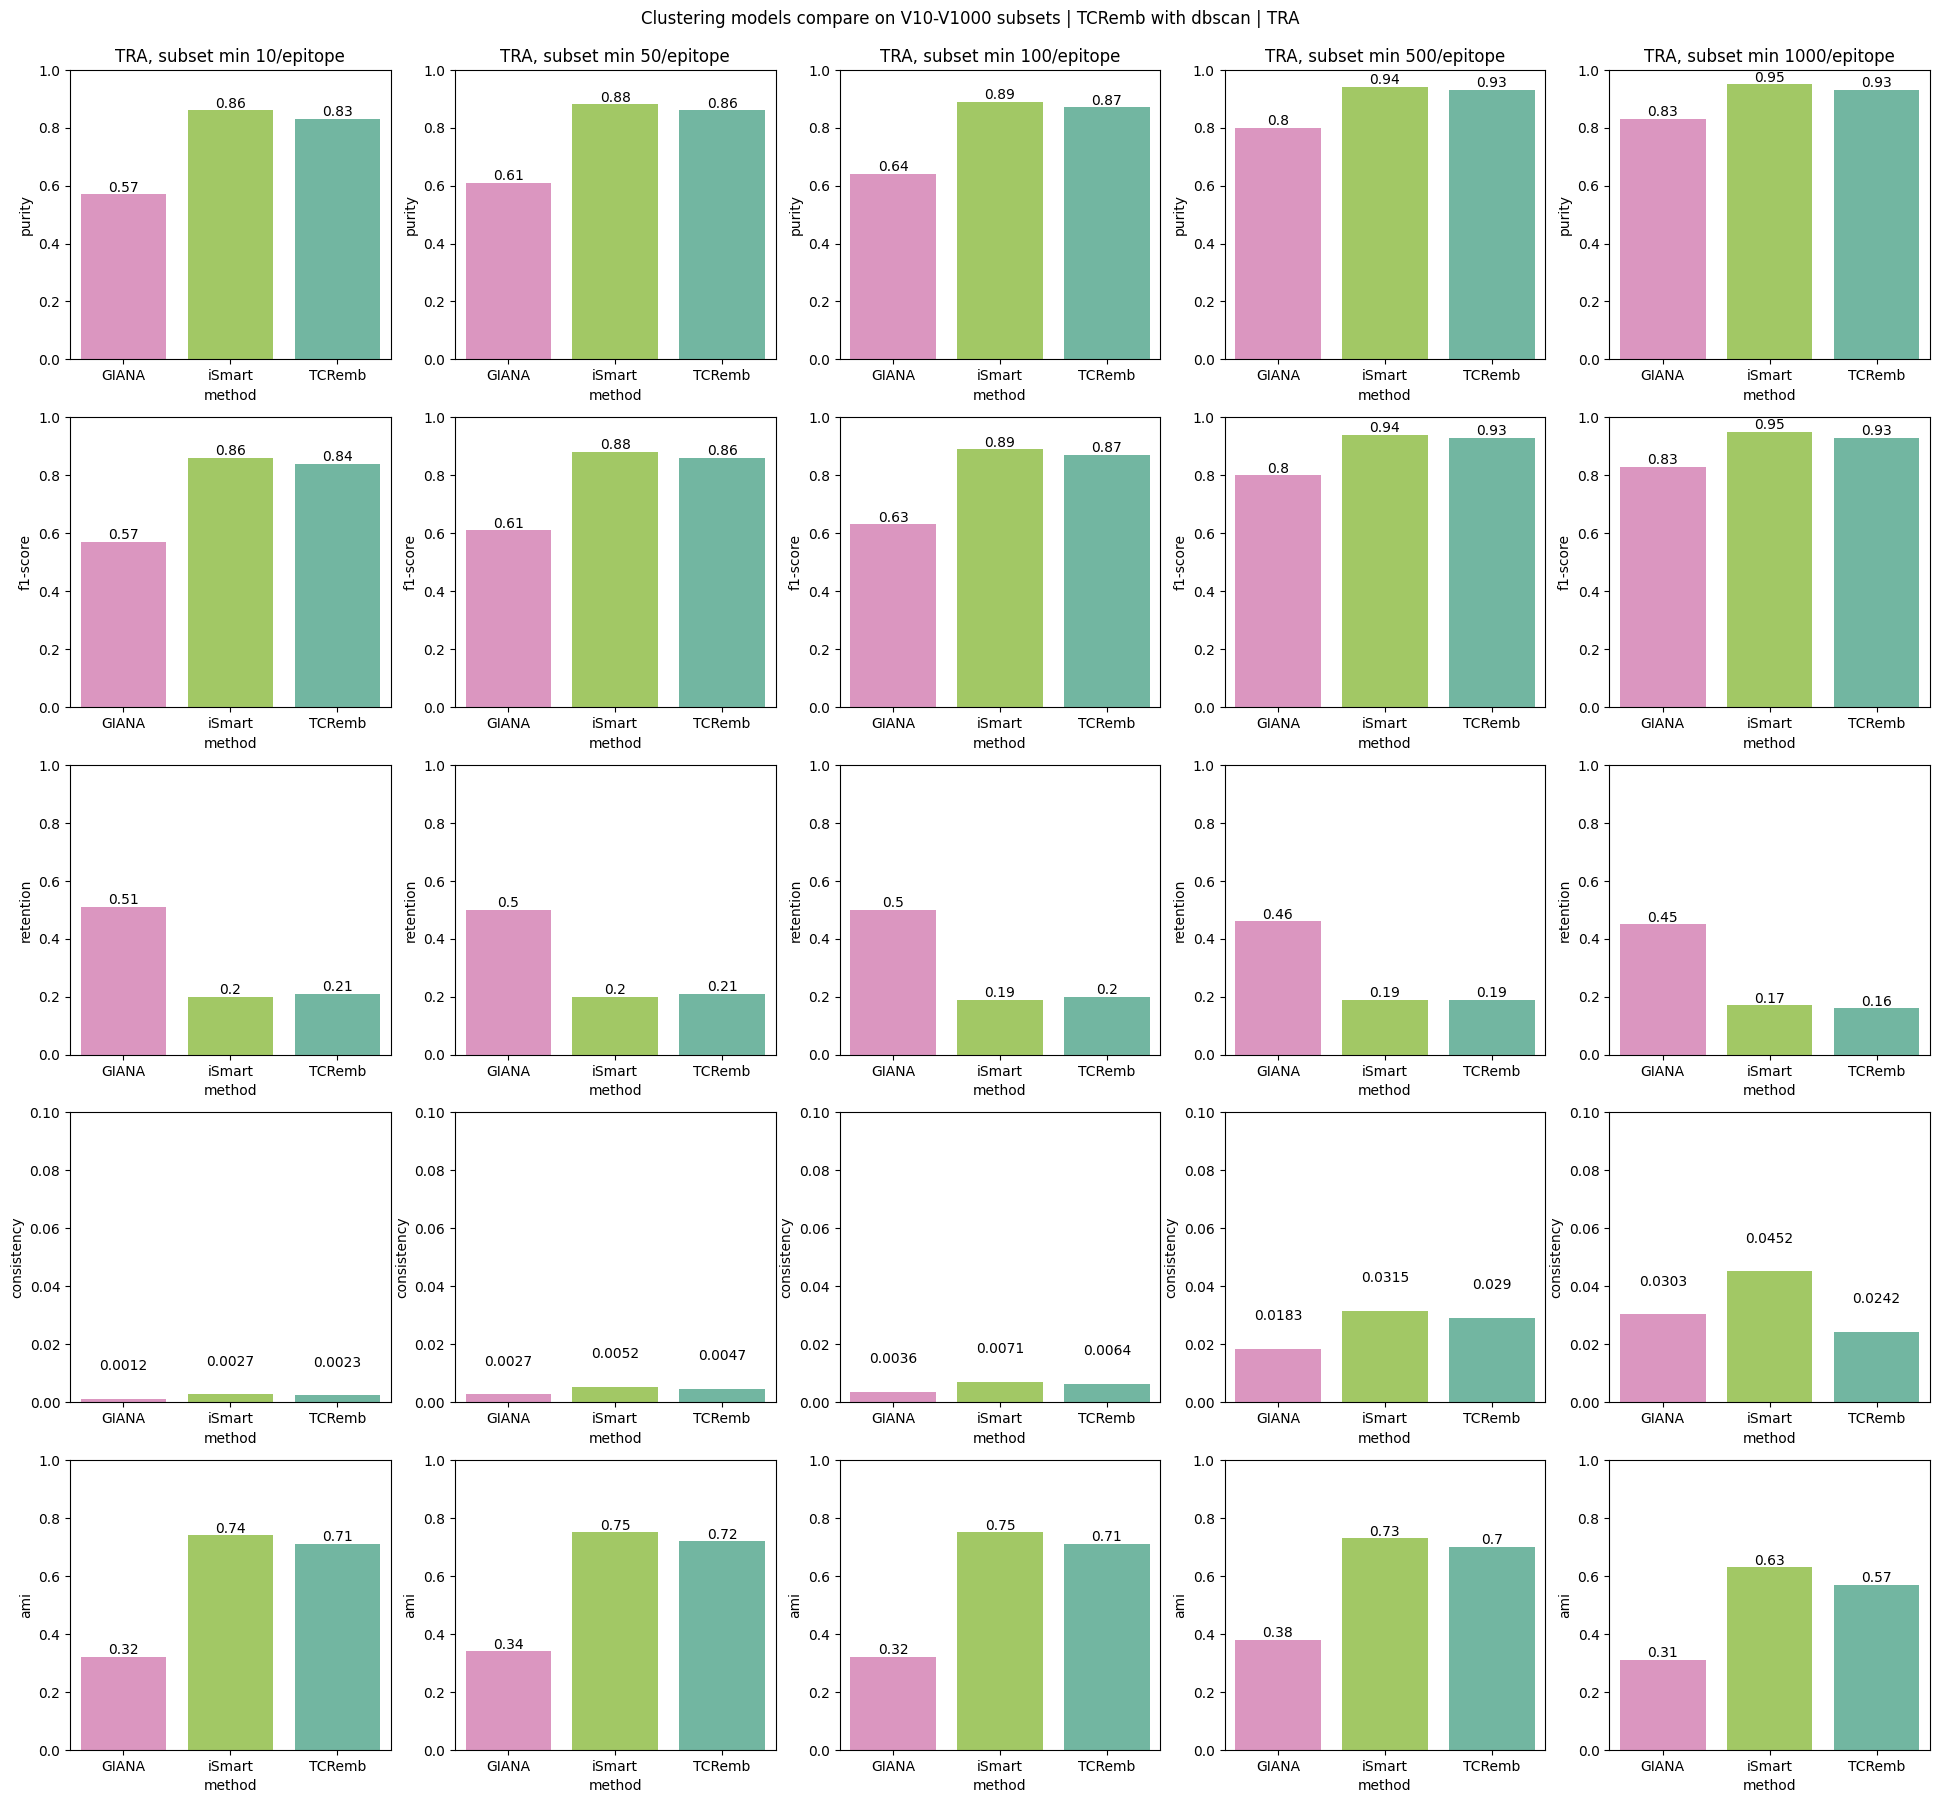

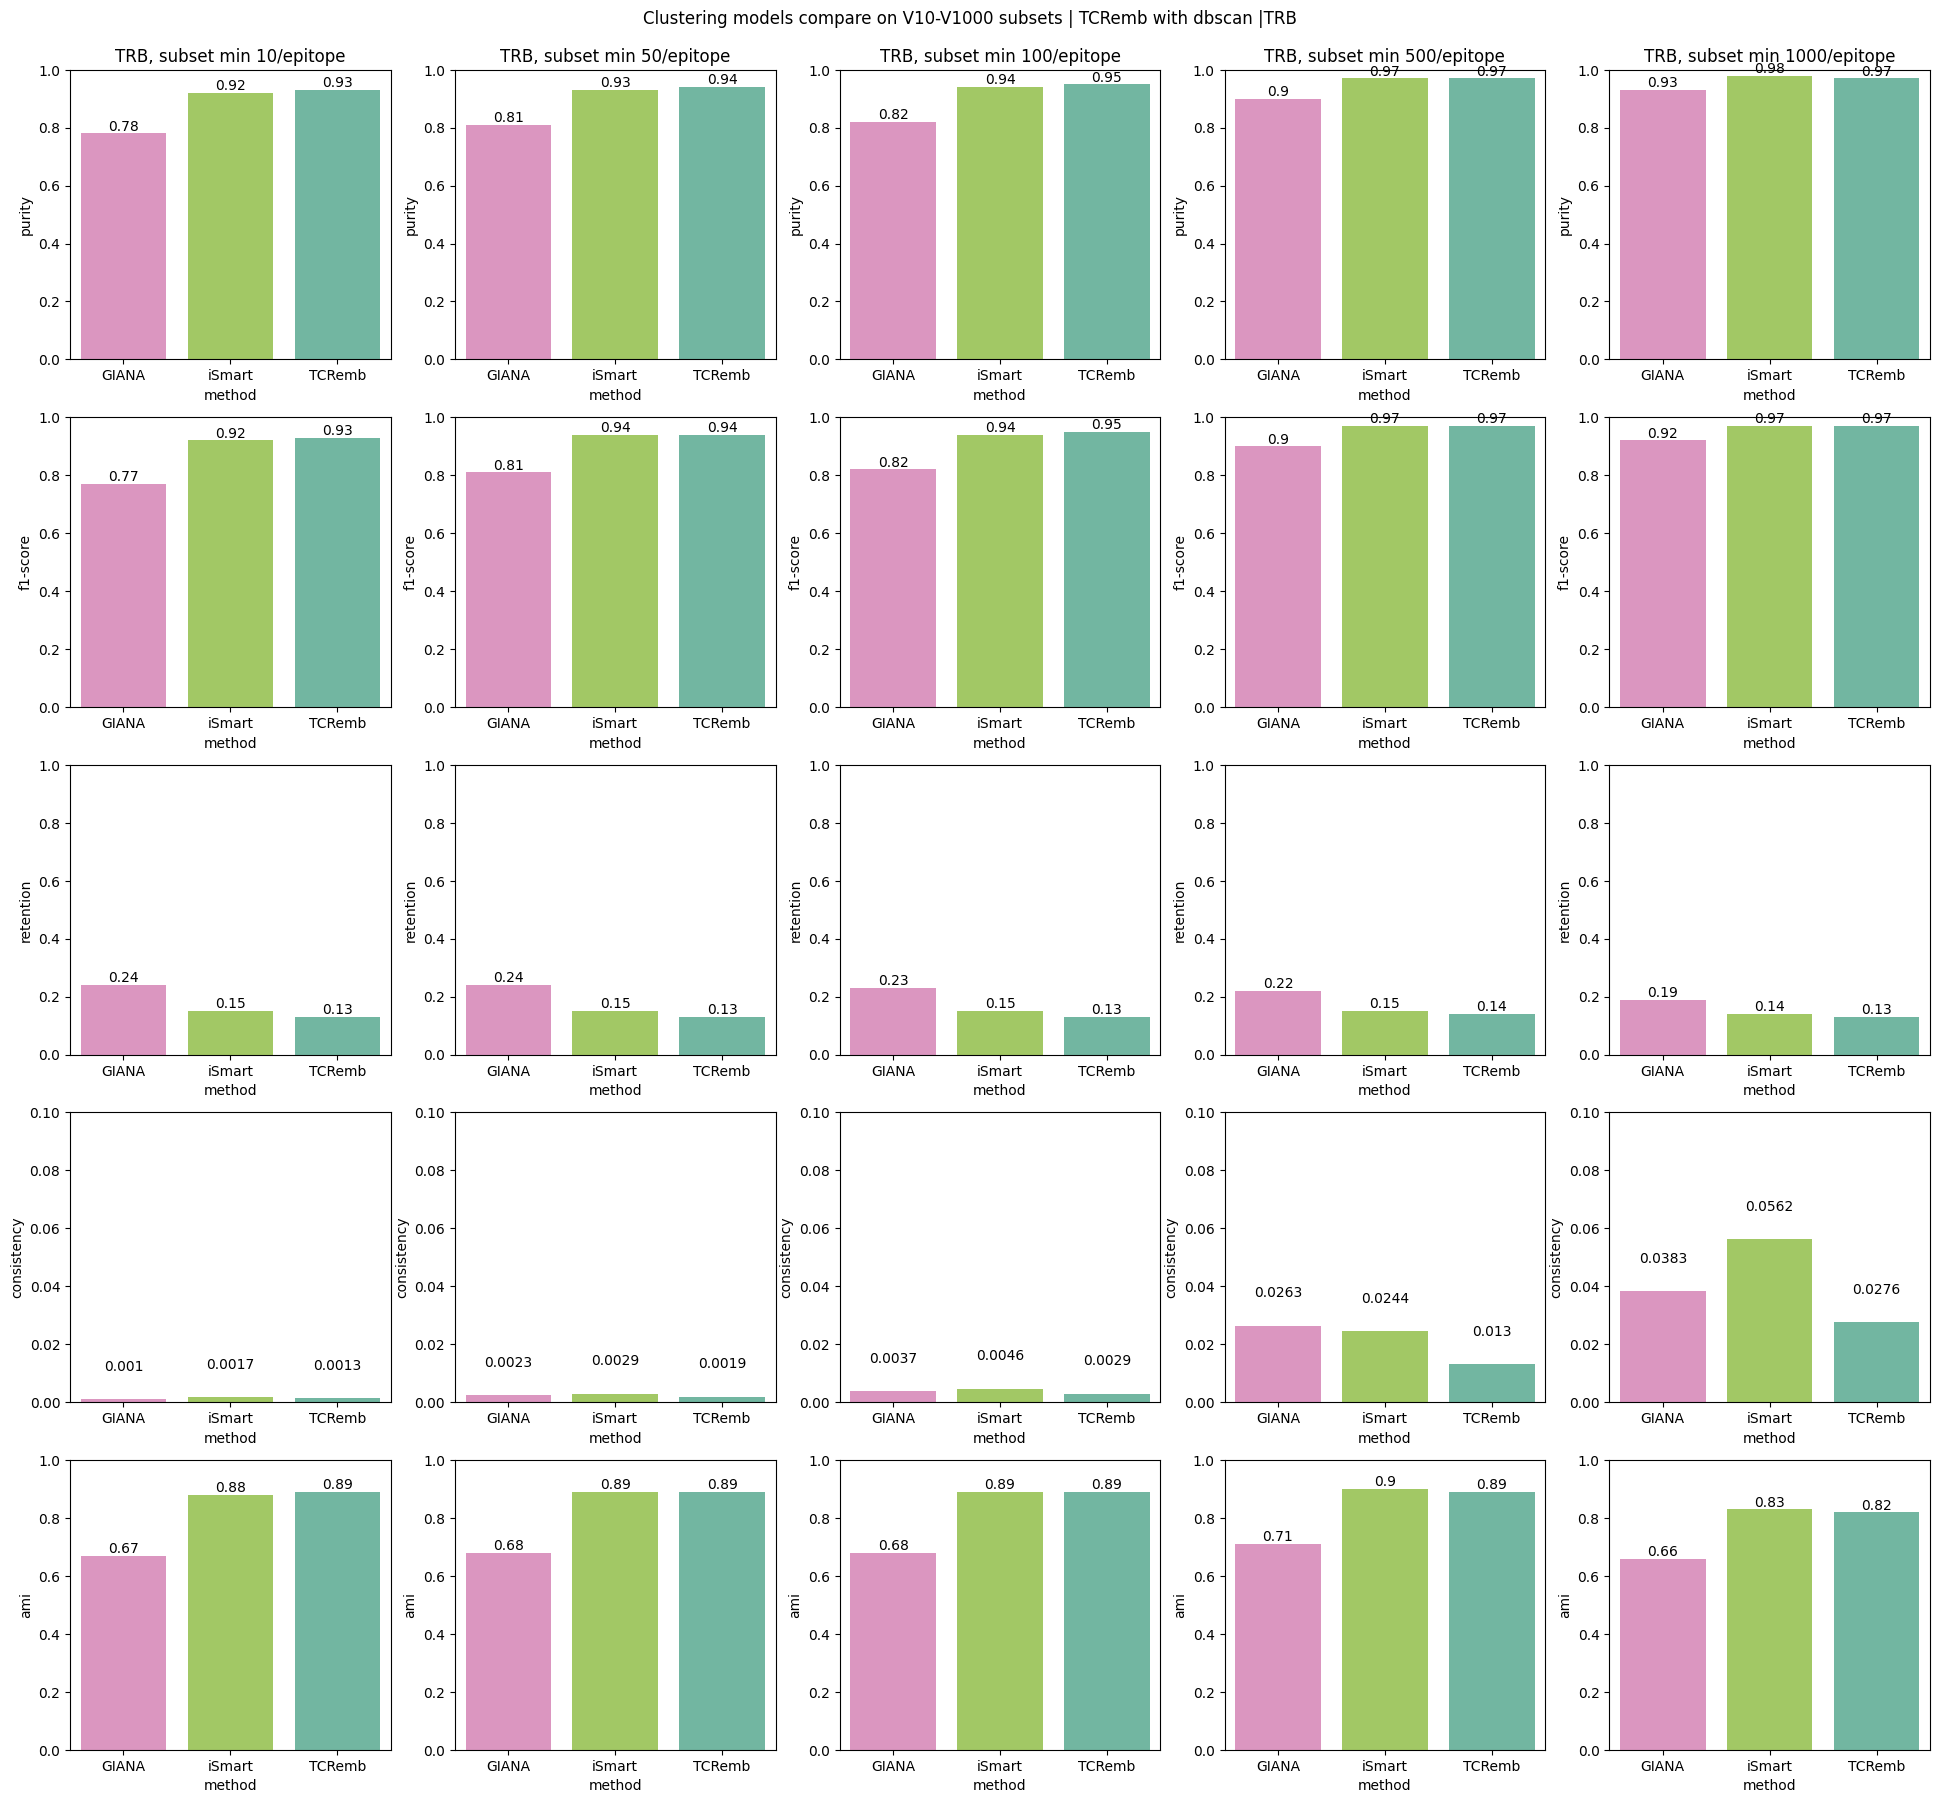

In [24]:
## dbscan

chain = 'TRA'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan | {chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')    
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
plt.savefig(f"results/figures/compare_methods_dbscan_no_dups_{chain}.png")

chain = 'TRB'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan |{chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
plt.savefig(f"results/figures/compare_methods_dbscan_no_dups_{chain}.png")

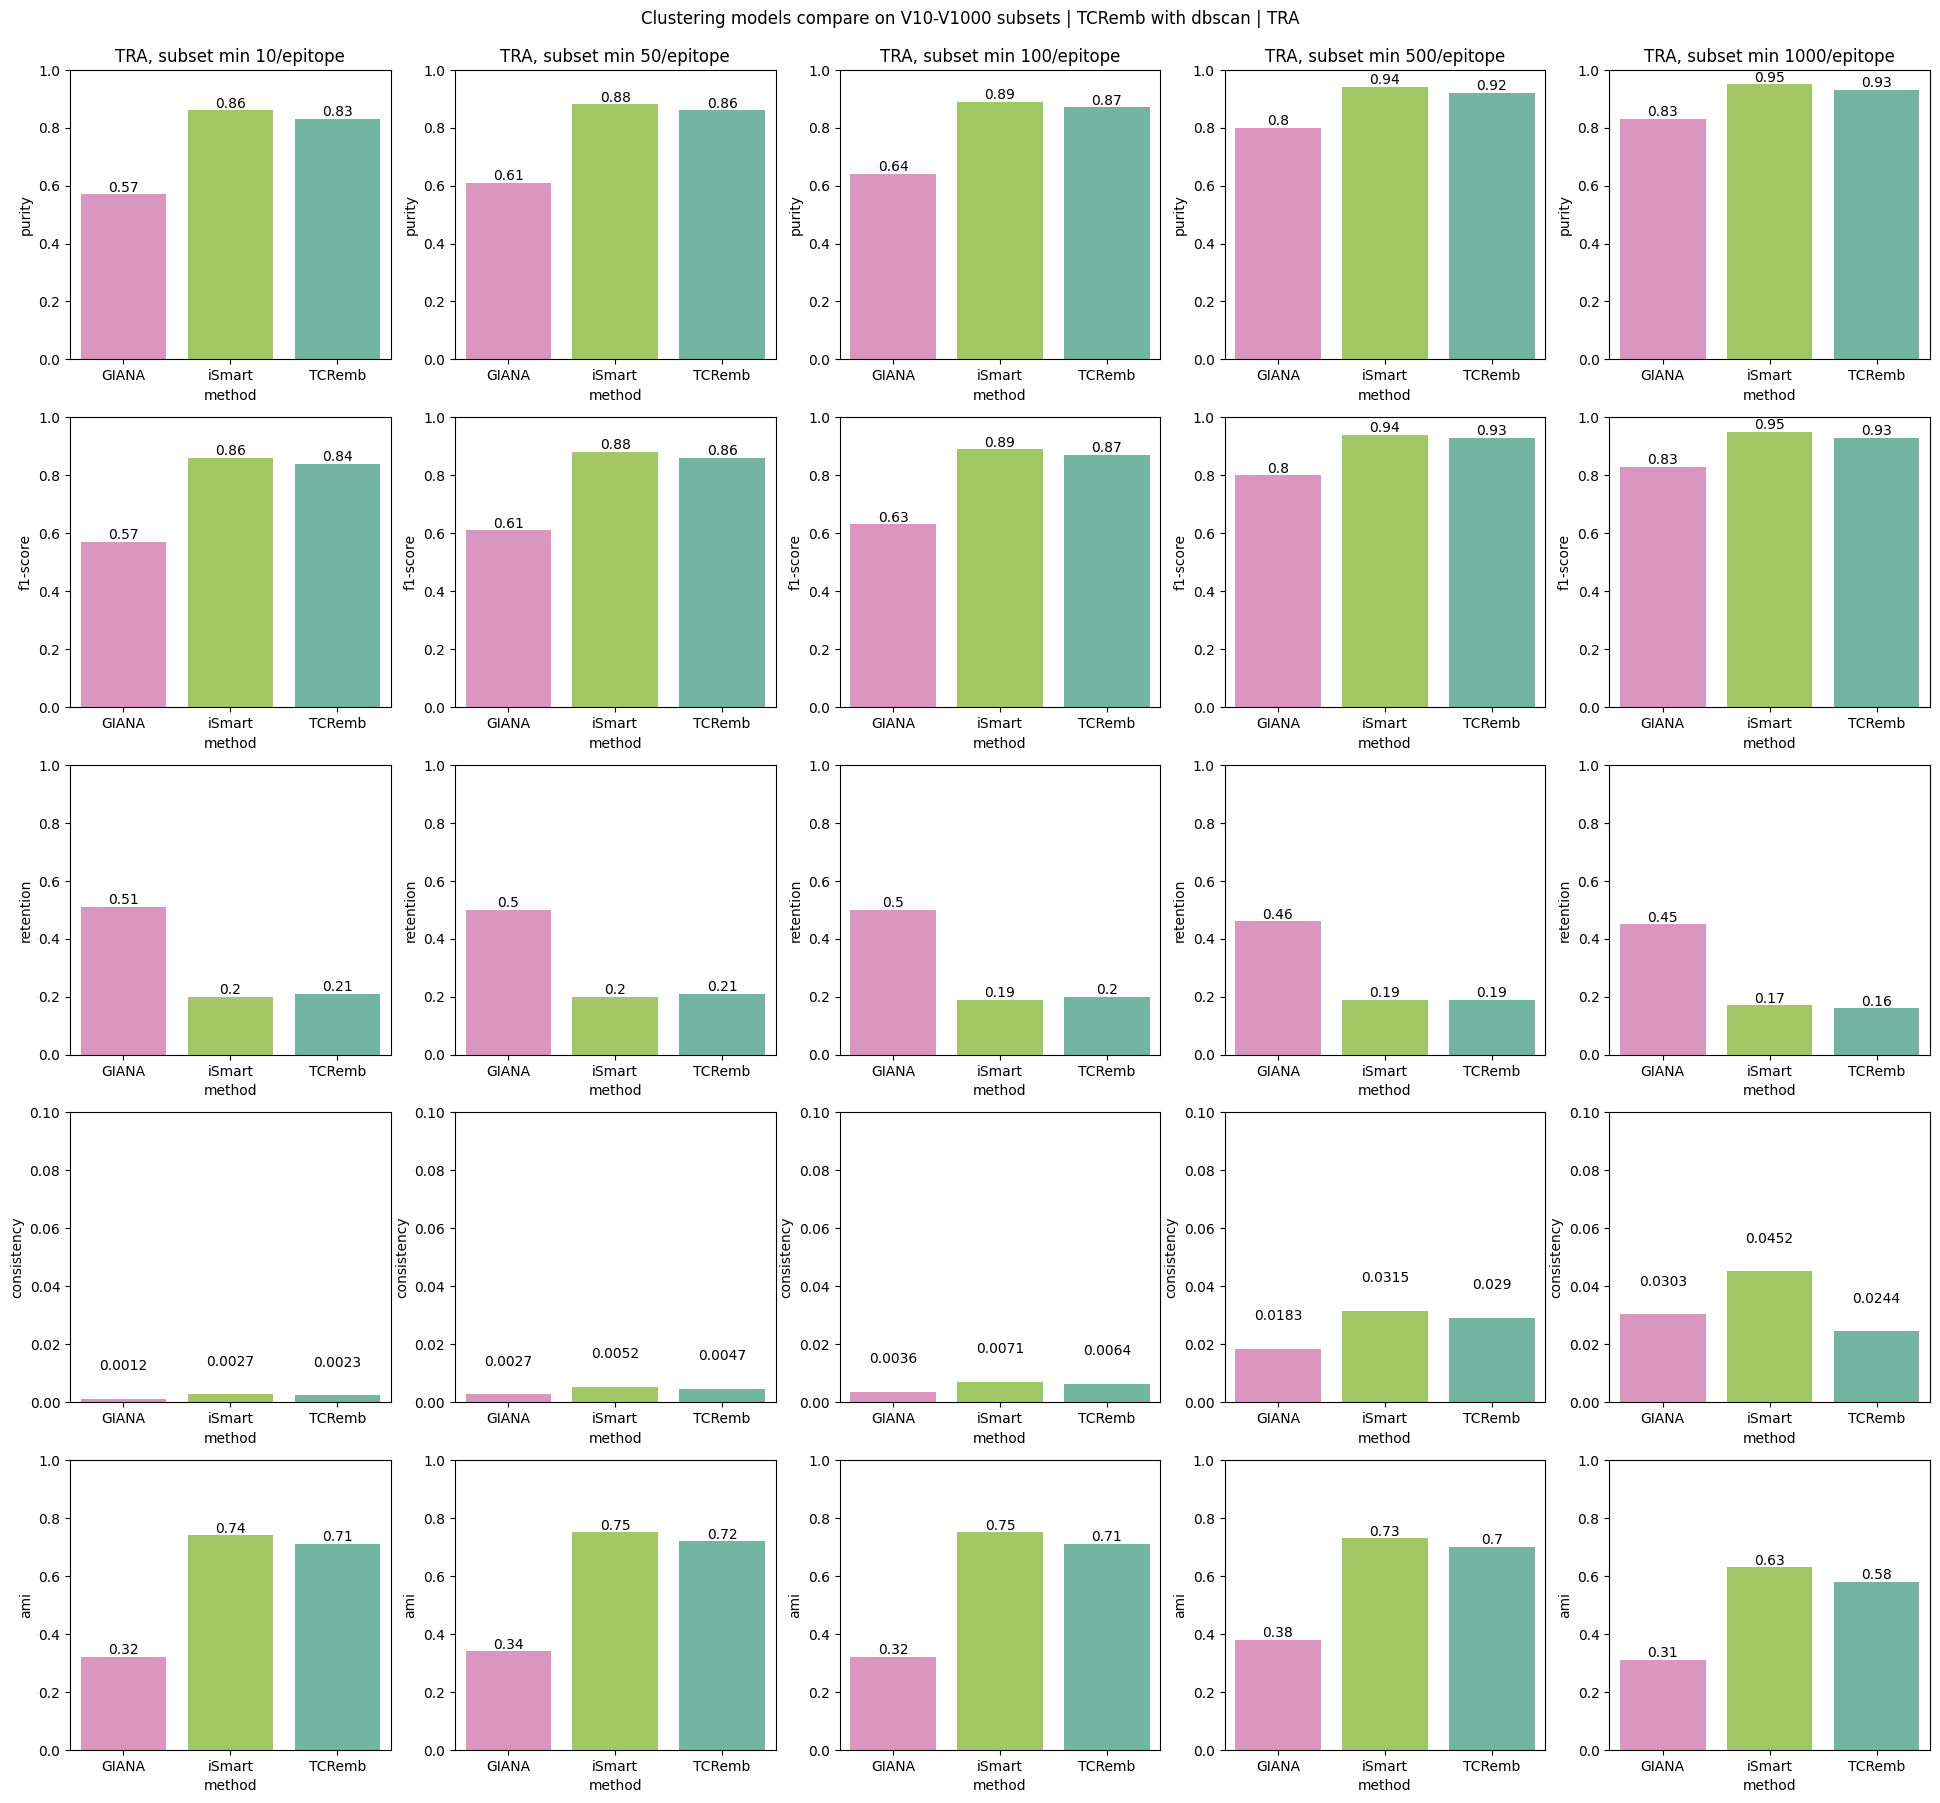

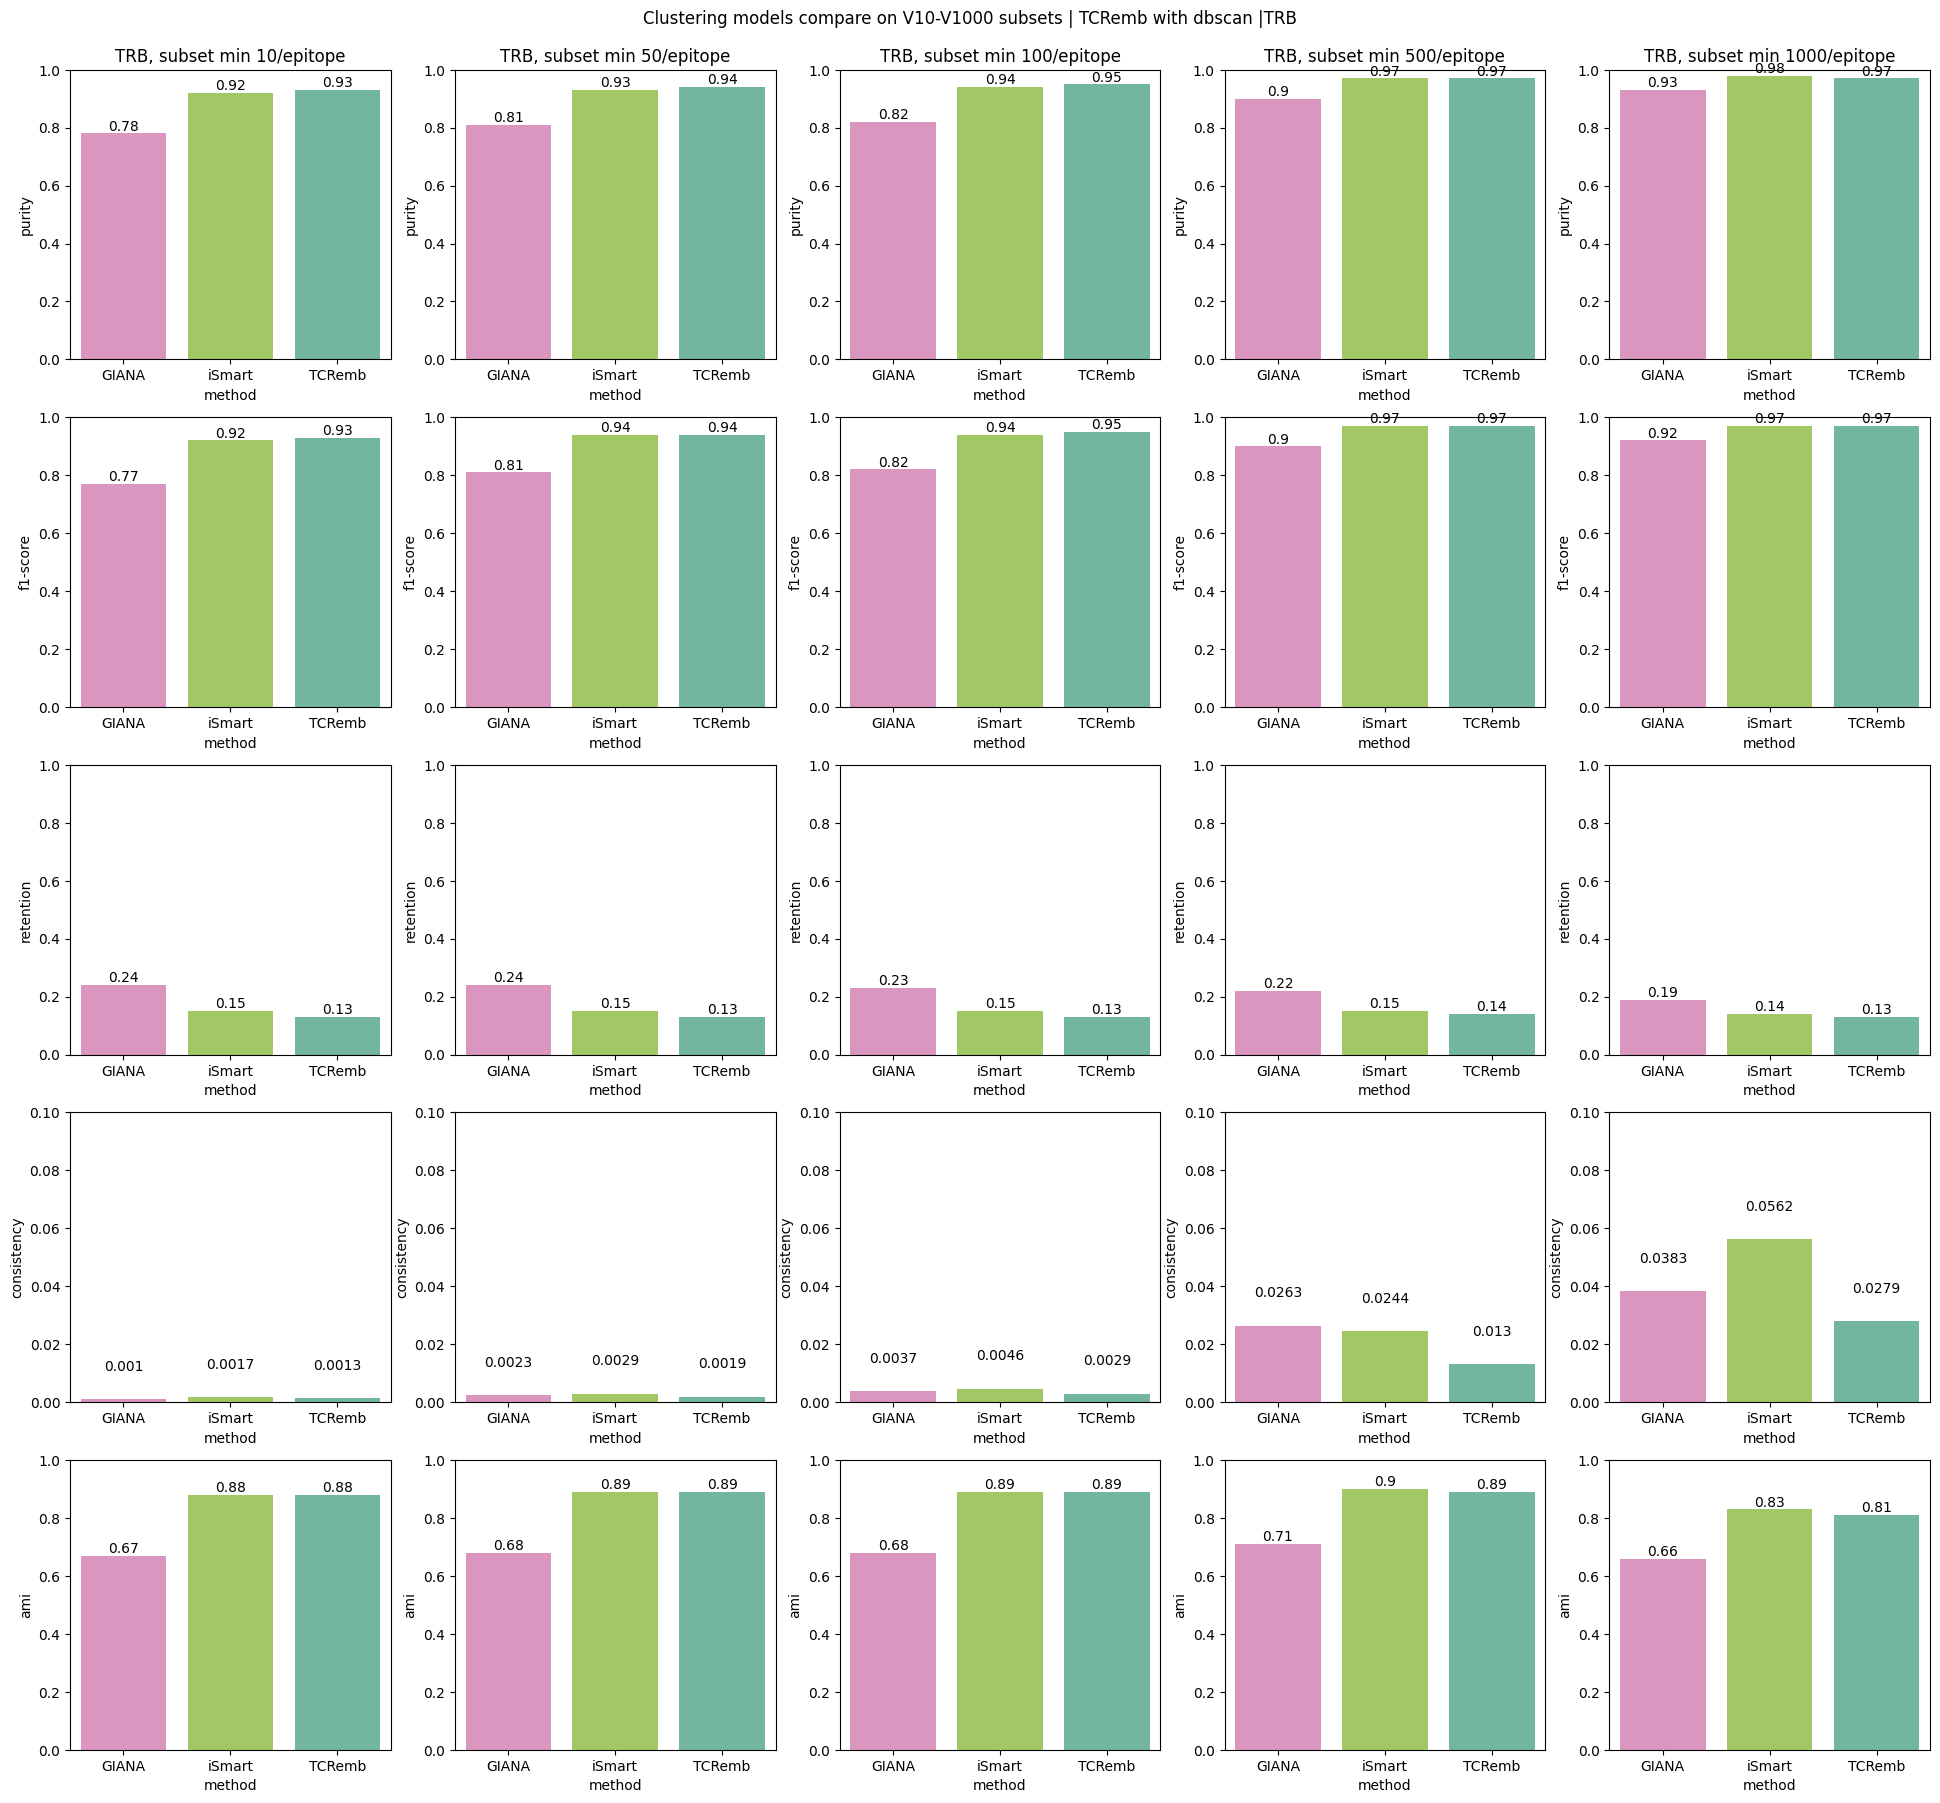

In [18]:
## dbscan

chain = 'TRA'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan | {chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')    
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
plt.savefig(f"results/figures/compare_methods_dbscan_no_dups_{chain}.png")

chain = 'TRB'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan |{chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
plt.savefig(f"results/figures/compare_methods_dbscan_no_dups_{chain}.png")

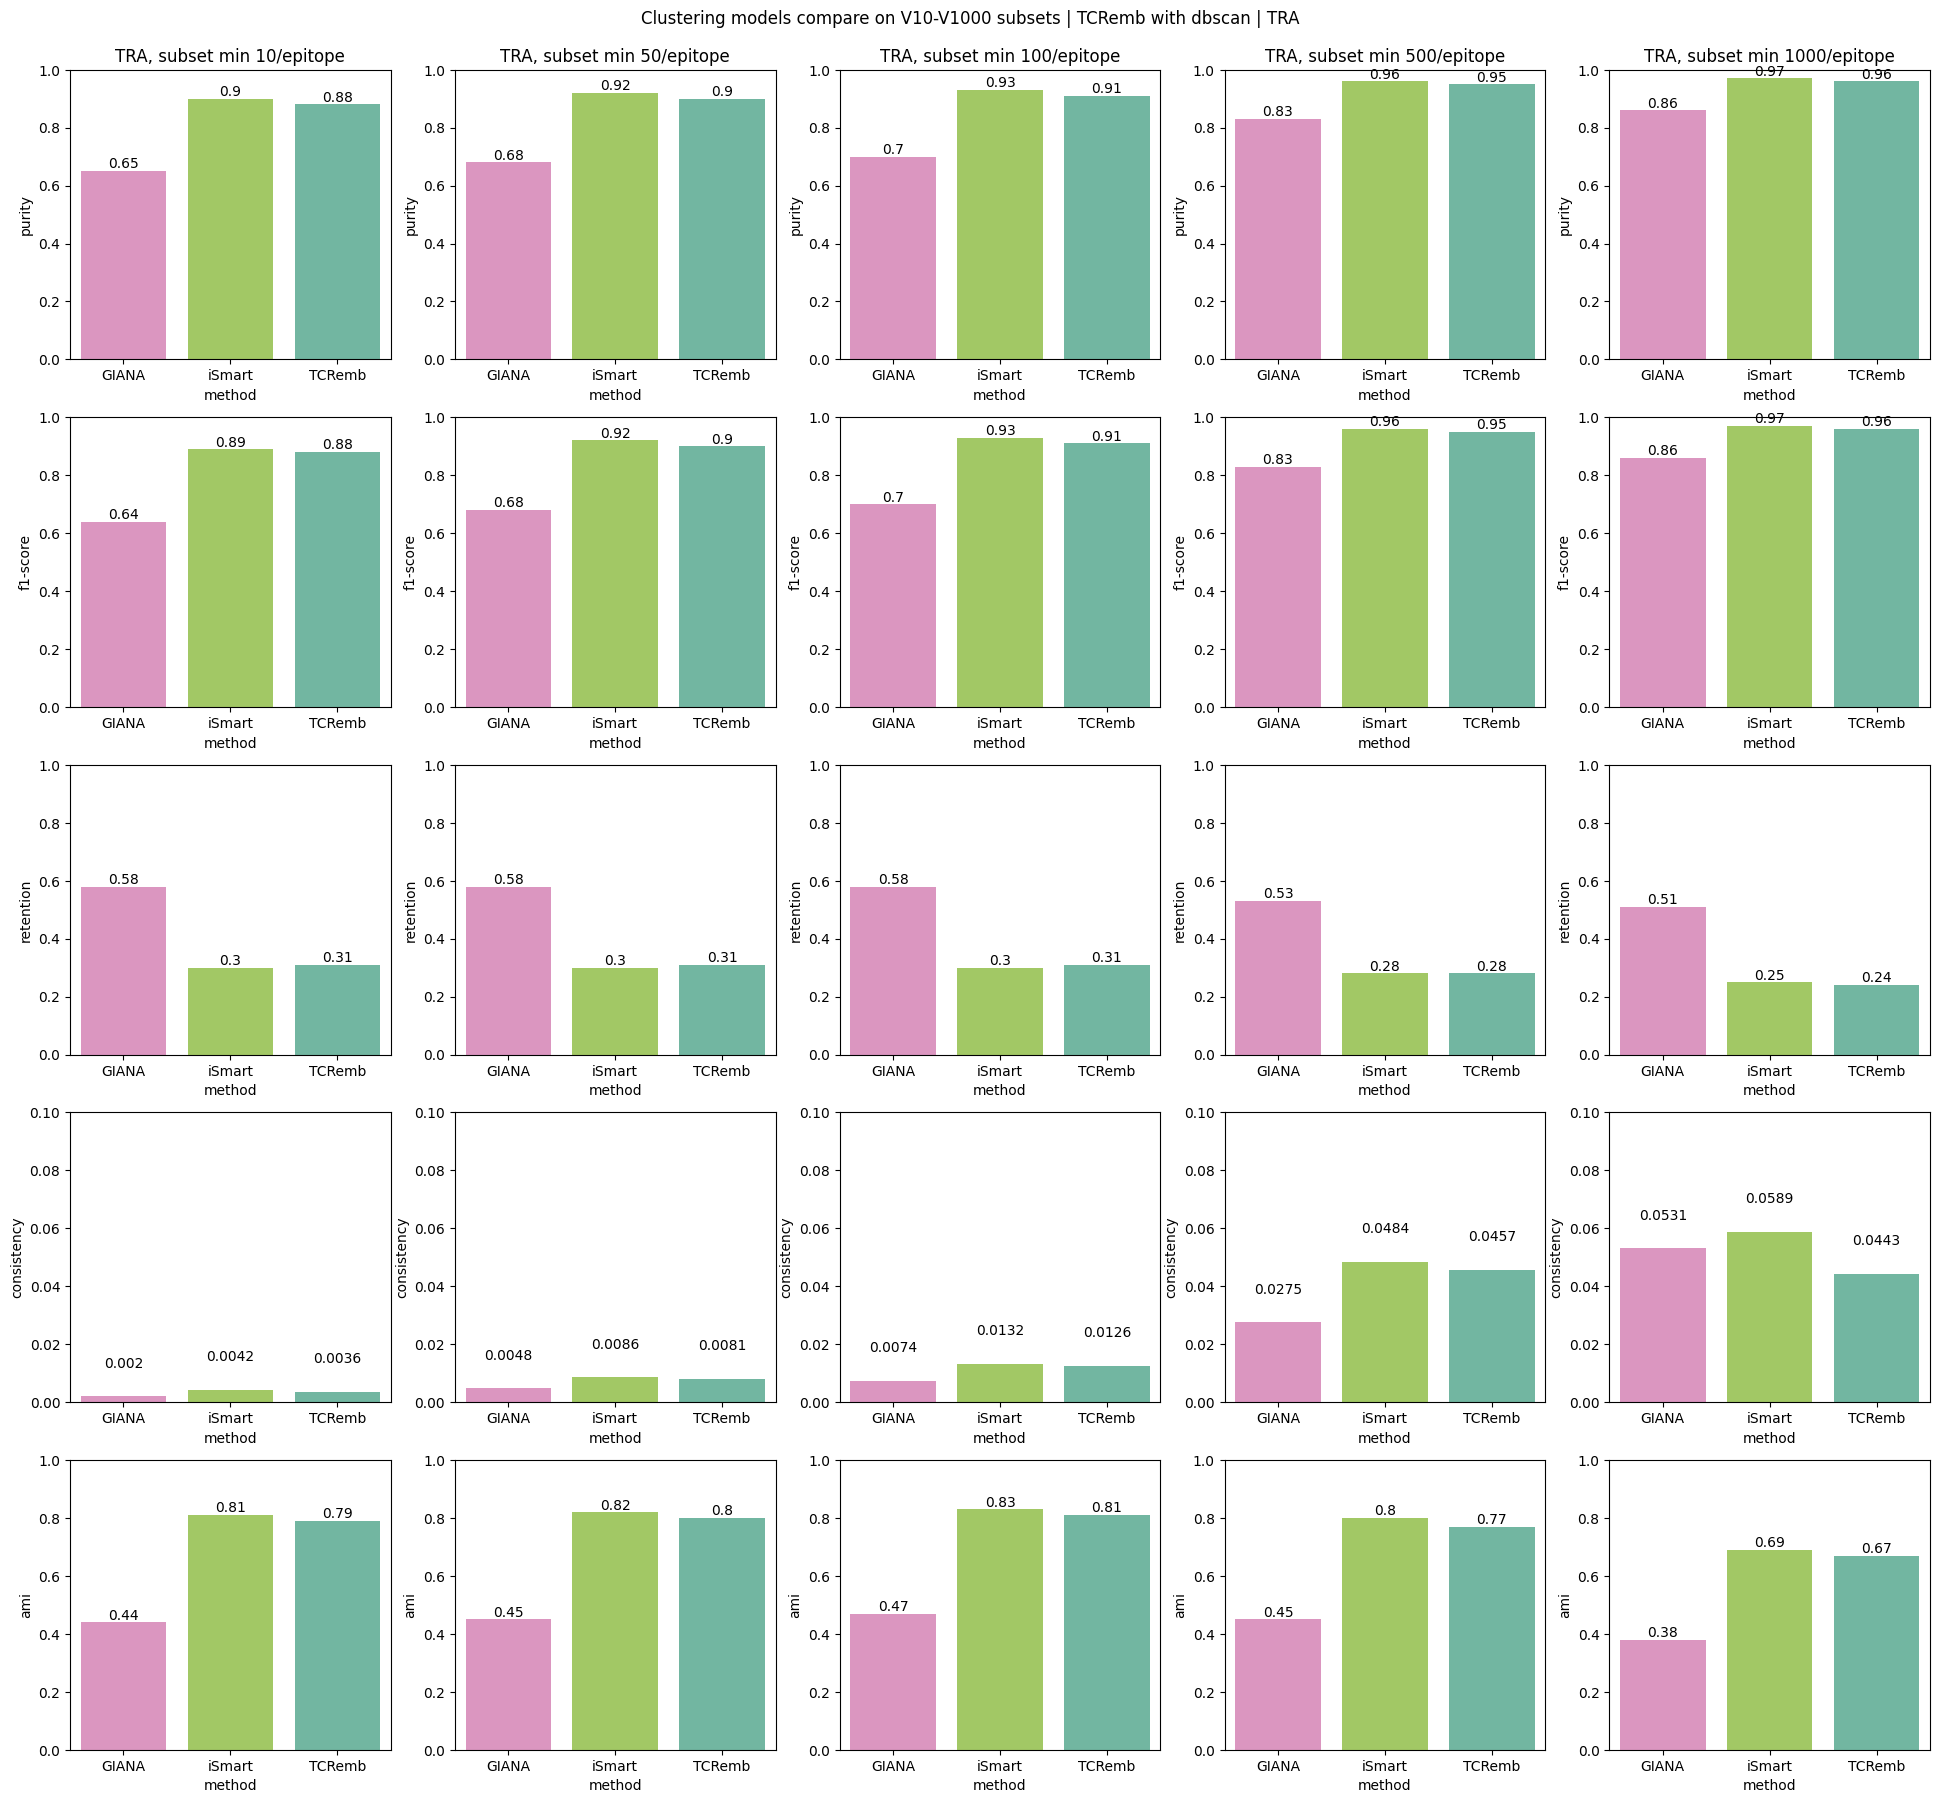

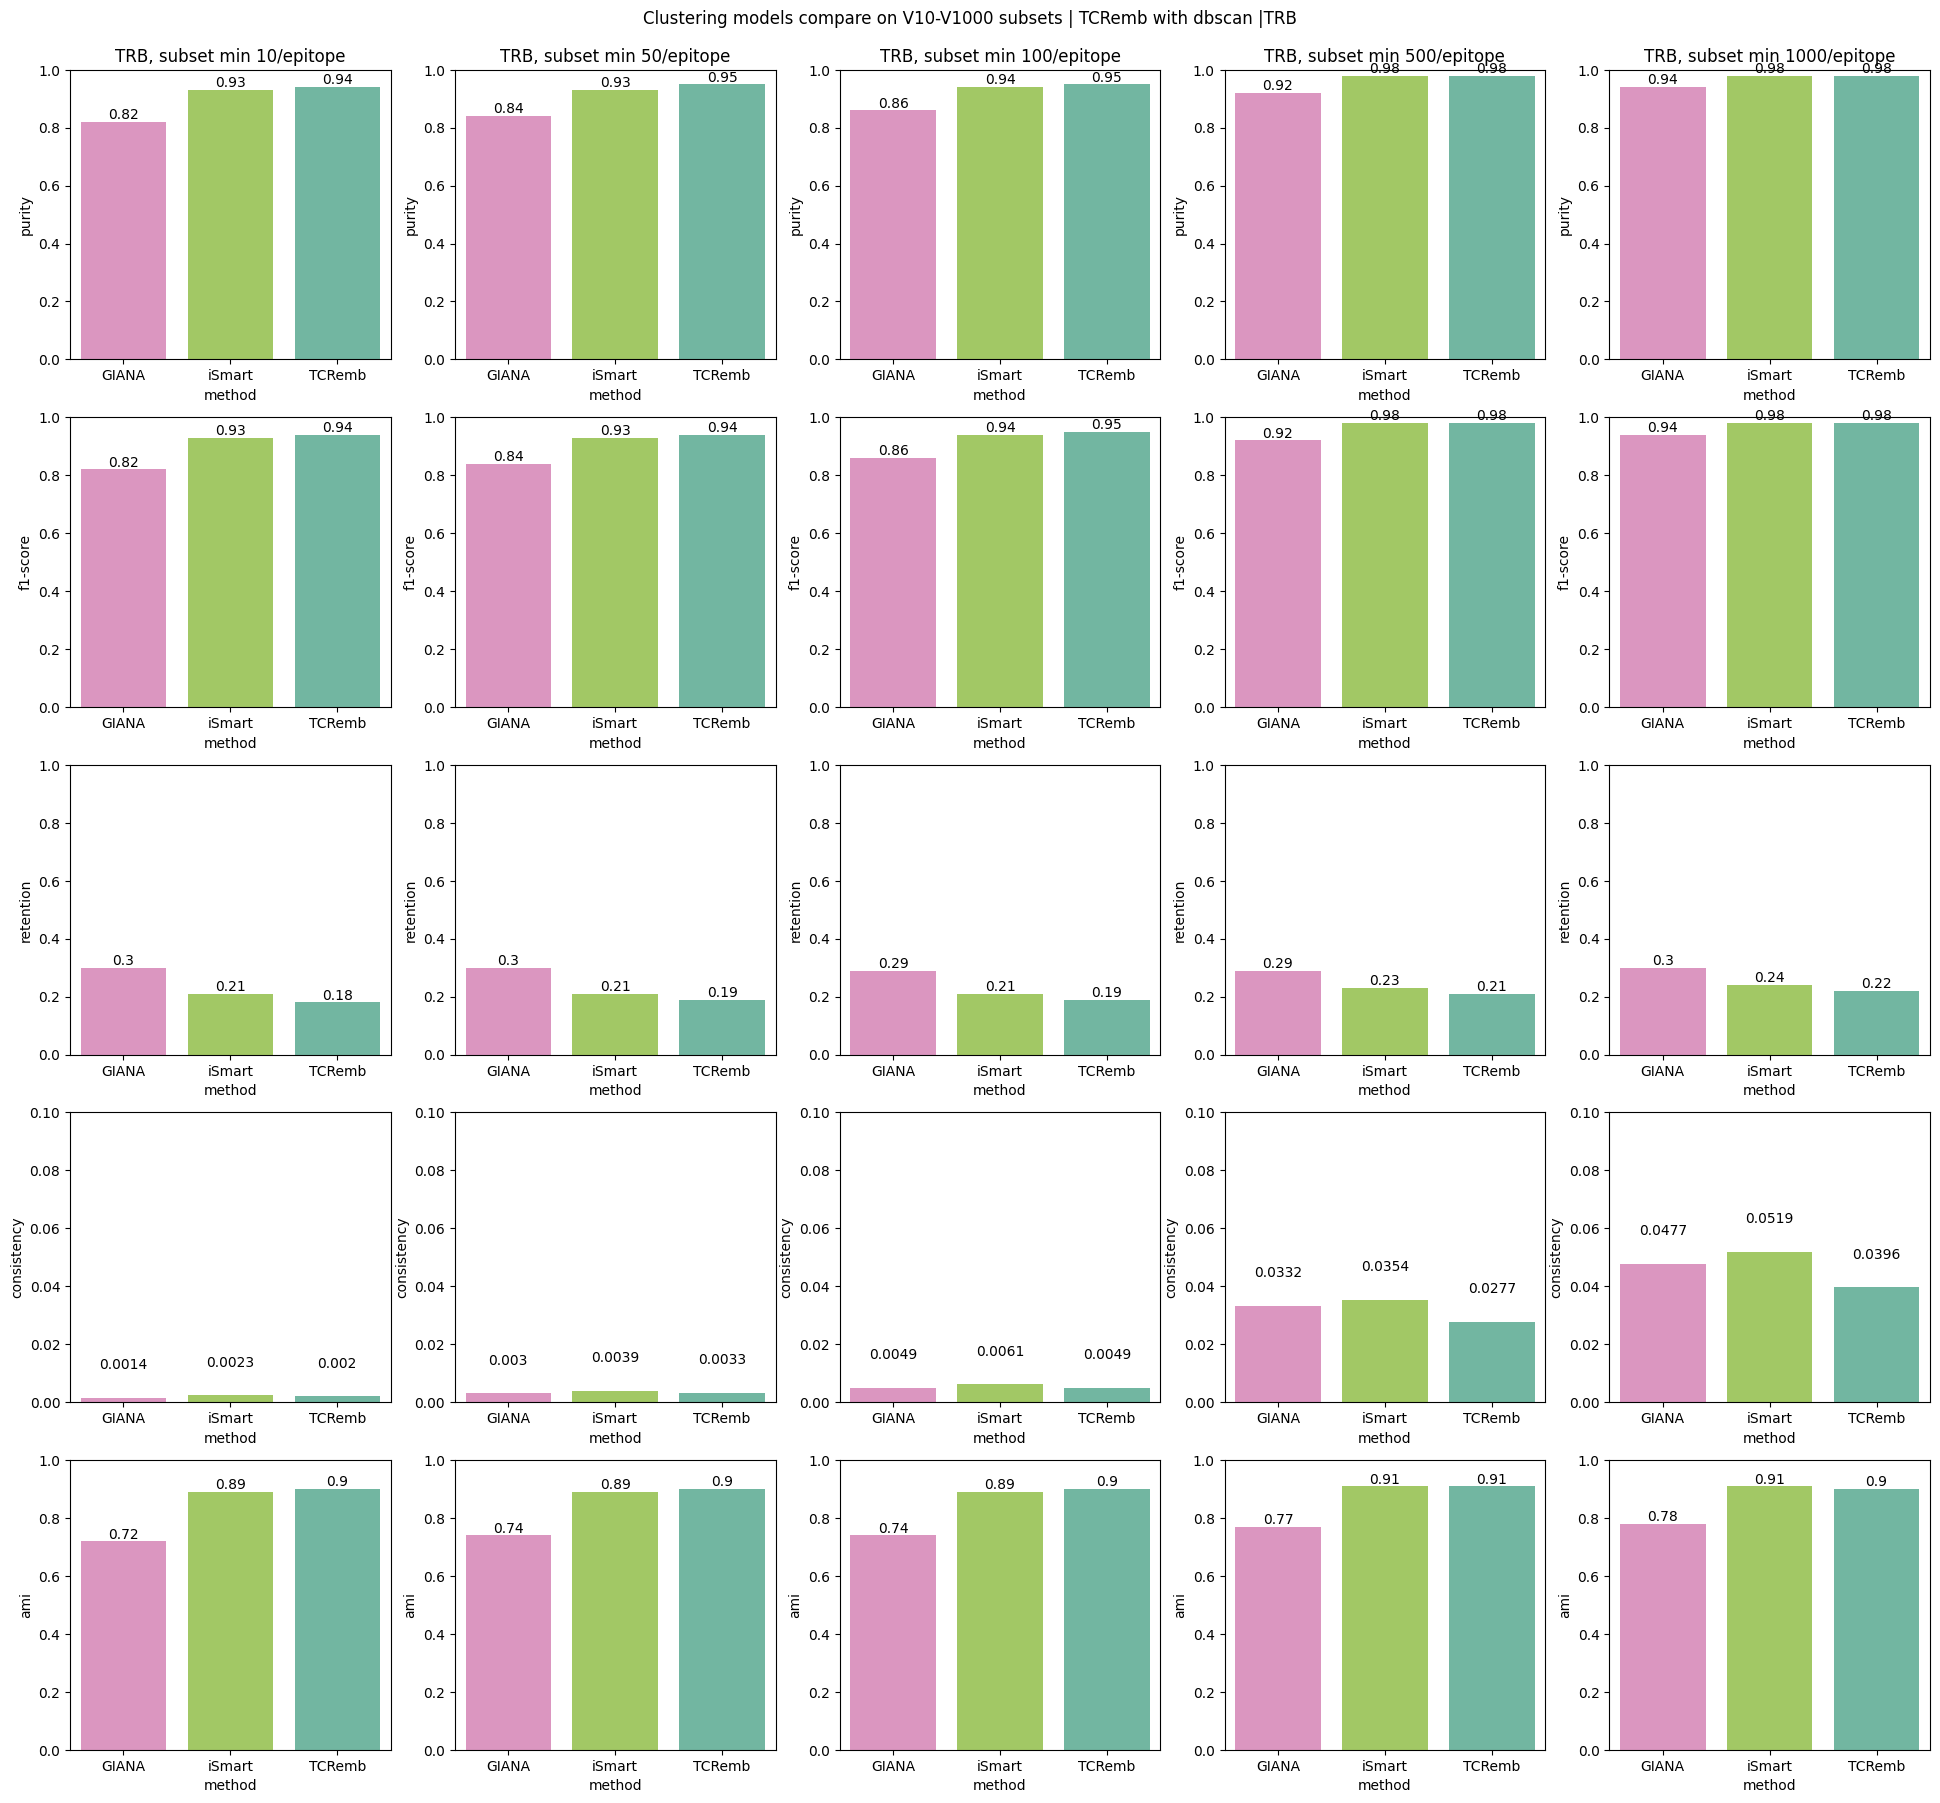

In [17]:
## dbscan

chain = 'TRA'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan | {chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')    
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
plt.savefig(f"results/figures/compare_methods_dbscan_{chain}.png")

chain = 'TRB'
fig, axes = plt.subplots(5,5, figsize = (24,20))
fig.suptitle(f'Clustering models compare on V10-V1000 subsets | TCRemb with dbscan |{chain}')
fig.subplots_adjust(top=0.95)
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[0,ax_n].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
        loc +=1
        axes[0,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[1,ax_n].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
        loc +=1
        axes[1,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[2,ax_n].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
        loc +=1
        axes[2,ax_n].set_ylim(0, 1)
    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[3,ax_n].text(loc, r['consistency'] + 0.01, round(r['consistency'],4), color='black', ha="center")
        loc +=1
        axes[3,ax_n].set_ylim(0, 0.1)
    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    loc = 0
    for i,r in t.iterrows():
        axes[4,ax_n].text(loc, r['ami'] + 0.01, round(r['ami'],2), color='black', ha="center")
        loc +=1
        axes[4,ax_n].set_ylim(0, 1)
        
    ax_n+=1
plt.savefig(f"results/figures/compare_methods_dbscan_{chain}.png")

In [19]:
chain='TRA'
metrics_v[chain].to_csv(f"results/tables/compare_methods_dbscan_nodups_{chain}.csv",index=False)
chain='TRB'
metrics_v[chain].to_csv(f"results/tables/compare_methods_dbscan_nodups_{chain}.csv",index=False)

In [20]:
chain='TRA'
metrics_v[chain]


,v_subset,purity,retention,consistency,ami,precision,recall,f1-score,mean_clustsize,method
0,10,0.57,0.51,0.0012,0.32,0.57,0.57,0.57,5.03,GIANA
1,50,0.61,0.5,0.0027,0.34,0.61,0.61,0.61,4.93,GIANA
2,100,0.64,0.5,0.0036,0.32,0.63,0.64,0.63,4.84,GIANA
3,500,0.8,0.46,0.0183,0.38,0.8,0.8,0.8,4.63,GIANA
4,1000,0.83,0.45,0.0303,0.31,0.83,0.83,0.83,4.64,GIANA
5,10,0.86,0.2,0.0027,0.74,0.86,0.86,0.86,3.37,iSmart
6,50,0.88,0.2,0.0052,0.75,0.88,0.88,0.88,3.45,iSmart
7,100,0.89,0.19,0.0071,0.75,0.89,0.89,0.89,3.45,iSmart
8,500,0.94,0.19,0.0315,0.73,0.94,0.94,0.94,3.87,iSmart
9,1000,0.95,0.17,0.0452,0.63,0.95,0.95,0.95,3.82,iSmart


In [21]:
chain='TRB'
metrics_v[chain]


,v_subset,purity,retention,consistency,ami,precision,recall,f1-score,mean_clustsize,method
0,10,0.78,0.24,0.001,0.67,0.77,0.78,0.77,3.64,GIANA
1,50,0.81,0.24,0.0023,0.68,0.81,0.81,0.81,3.64,GIANA
2,100,0.82,0.23,0.0037,0.68,0.82,0.82,0.82,3.75,GIANA
3,500,0.9,0.22,0.0263,0.71,0.9,0.9,0.9,4.32,GIANA
4,1000,0.93,0.19,0.0383,0.66,0.92,0.93,0.92,4.04,GIANA
5,10,0.92,0.15,0.0017,0.88,0.92,0.92,0.92,3.64,iSmart
6,50,0.93,0.15,0.0029,0.89,0.94,0.93,0.94,3.69,iSmart
7,100,0.94,0.15,0.0046,0.89,0.94,0.94,0.94,3.86,iSmart
8,500,0.97,0.15,0.0244,0.9,0.97,0.97,0.97,4.5,iSmart
9,1000,0.98,0.14,0.0562,0.83,0.97,0.98,0.97,4.85,iSmart


In [23]:
chain='TRA'
metrics_v[chain].to_csv(f"results/tables/compare_methods_dbscan_{chain}.csv",index=False)
chain='TRB'
metrics_v[chain].to_csv(f"results/tables/compare_methods_dbscan_{chain}.csv",index=False)

In [25]:
metrics_v['TRB']

,v_subset,purity,retention,consistency,ami,precision,recall,f1-score,mean_clustsize,method
0,10,0.82,0.3,0.0014,0.72,0.81,0.82,0.82,5.48,GIANA
1,50,0.84,0.3,0.003,0.74,0.84,0.84,0.84,5.64,GIANA
2,100,0.86,0.29,0.0049,0.74,0.86,0.86,0.86,5.73,GIANA
3,500,0.92,0.29,0.0332,0.77,0.92,0.92,0.92,6.77,GIANA
4,1000,0.94,0.3,0.0477,0.78,0.94,0.94,0.94,7.12,GIANA
5,10,0.93,0.21,0.0023,0.89,0.93,0.93,0.93,6.13,iSmart
6,50,0.93,0.21,0.0039,0.89,0.93,0.93,0.93,6.37,iSmart
7,100,0.94,0.21,0.0061,0.89,0.94,0.94,0.94,6.64,iSmart
8,500,0.98,0.23,0.0354,0.91,0.98,0.98,0.98,7.86,iSmart
9,1000,0.98,0.24,0.0519,0.91,0.98,0.98,0.98,8.54,iSmart


In [ ]:
chain = 'TRA'
fig, axes = plt.subplots(5,5, figsize = (20,18))
ax_n = 0
for i in samples_n:
    t = metrics_v[chain][metrics_v[chain]['v_subset']==i]
    sns.barplot(data = t, x = 'method', y = 'purity', palette= color_map, ax = axes[0,ax_n]).set_title(f'{chain}, subset min {i}/epitope')
    
    sns.barplot(data = t, x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'retention', palette= color_map, ax = axes[2,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'consistency', palette= color_map, ax = axes[3,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')

    
    sns.barplot(data = t, x = 'method', y = 'ami', palette= color_map, ax = axes[4,ax_n])#.set_title(f'{chain}, subset min {i}/epitope')
    ax_n+=1

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

In [ ]:
chain = 'TRA'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_enriched[chain]).T])
#metrics_v[chain]['method'] = metrics_v[chain].index

chain = 'TRB'
metrics_v[chain] = pd.concat([
    pd.DataFrame(metrics_giana_v[chain]).T
    ,pd.DataFrame(metrics_ismart_v[chain]).T
    #,pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
    , pd.DataFrame(metrics_tcremb_v_enriched[chain]).T])

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_v[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_v[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

plt.savefig(f"results/figures/compare_methods_3.png")

# Classification

## ATM_TCR

2650 11772 505 6706
accuracy   0.4325
auc        0.6519
f1macro    0.4118
f1micro    0.4325
loss       442818.7955
precision0 0.8399
precision1 0.3629
recall0    0.1837
recall1    0.9300

In [ ]:
atm_results_path = '/home/ykremlyakova/apps/ATM-TCR/result/pred_my_model_vdjdb_trb_atmtcr_test.csv'
real_test_path = '/home/ykremlyakova/projects/tcr_emb/data/data_preped/vdjdb_trb_atmtcr_test.csv'

In [ ]:
!pwd

In [ ]:
real_test = pd.read_csv(real_test_path,header=None)
real_test

In [ ]:
atm = pd.read_csv(atm_results_path, sep='\t',header=None)
atm = atm.rename({0:'antigen.epitope',1:'cdr3aa',2:'bind',3:'pred'},axis=1)

In [ ]:
epitopes_list = ['CINGVCWTV',
 'ELAGIGILTV',
 'FRDYVDRFYKTLRAEQASQE',
 'GILGFVFTL',
 'GLCTLVAML',
 'KRWIILGLNK',
 'LLLGIGILV',
 'LLWNGPMAV',
 'NLVPMVATV',
 'PKYVKQNTLKLAT',
 'SPRWYFYYL',
 'TFEYVSQPFLMDLE',
 'TPRVTGGGAM',
 'TTDPSFLGRY',
 'YLQPRTFLL']

In [ ]:
atm_e = atm[atm['antigen.epitope'].isin(epitopes_list)]

In [ ]:
#atm_e = atm_e[atm_e['bind']==1]

In [ ]:
roc_res = []
for e in epitopes_list:
    r={}
    r['class']= e
    r['roc_auc'] = ml_utils.roc_auc_count_binary(atm_e[atm_e['antigen.epitope']==e]['bind'], atm_e[atm_e['antigen.epitope']==e]['pred'])
    roc_res.append(r)

In [ ]:
roc_res


In [ ]:
atm_e[atm_e['pred'].isna()]